In [2]:
import matplotlib.pyplot as plt

# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
from matplotlib import ticker

from sklearn import manifold

import numpy as np
from skimage.transform import resize
from skimage.morphology import area_closing

In [3]:
def image_resize(img, sz):
    return resize(img, sz)

def op_norm(arr:np.array):
    return (arr - arr.min()) / (arr.max() - arr.min())

# try to use closing technique for agg output to make it continuous first
def op_area_closing(arr, area_threshold, connectivity=1):
    arr_close = area_closing(arr, area_threshold, connectivity)
    return arr_close

def plot_3d(points, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=z, s=50, alpha=0.8)
    # ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()


def plot_2d(points, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points[:,:,2])
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

def apply_colormap(z_vals, cmap_name='gray'):
    """
    Apply a colormap to a 2D numpy array and return the corresponding RGBA values.

    Parameters:
    - z_vals: 2D numpy array of scalar values.
    - cmap_name: String name of the colormap to use.

    Returns:
    - color_mapped: 3D numpy array with an RGBA color mapped from each z value.
    """
    # Normalize z_vals to the range [0, 1]
    norm = plt.Normalize(vmin=z_vals.min(), vmax=z_vals.max())
    
    # Get the colormap
    cmap = plt.cm.get_cmap(cmap_name)
    
    # Apply the colormap (including normalization)
    color_mapped = cmap(norm(z_vals))
    
    return color_mapped

def figure_show(fig, idx=None, vmin=None, vmax=None):
    if idx is None:
        plt.figure()
    else:
        plt.figure(idx)
    
    # If vmin and vmax are not provided, use the min and max values of the image.
    if vmin is None:
        vmin = fig.min()
    if vmax is None:
        vmax = fig.max()
    # Display the image with the specified vmin and vmax
    img = plt.imshow(fig, vmin=vmin, vmax=vmax)
    # Add a colorbar with the correct scaling.
    plt.colorbar(img)
    plt.show()

In [4]:
# normalize the distribution by mean and std
# do we have to exclude the val == 0 pixels?
def distribution_normalize(arr:np.array):
    mu = np.mean(arr)
    sigma = np.std(arr)
    return (arr - mu) / sigma

def distribution_minmax(arr:np.array):
    return (arr - arr.min()) / (arr.max() - arr.min())  

In [5]:
import ot
import cv2

def ot_transport_laplace(Xs, Xt):
    ot_emd_laplace = ot.da.EMDLaplaceTransport(reg_lap=100, reg_src=1, similarity='gauss')
    ot_emd_laplace.fit(Xs=Xs, Xt=Xt)

    transp_Xs_laplace = ot_emd_laplace.transform(Xs=Xs)
    return transp_Xs_laplace

def ot_transport_emd(Xs, Xt):
    ot_emd = ot.da.EMDTransport()
    ot_emd.fit(Xs=Xs, Xt=Xt)

    transp_Xs_emd = ot_emd.transform(Xs=Xs)
    return transp_Xs_emd

def ot_transport_mapping_linear(Xs, Xt, mu=1e0, eta=1e-8, bias=True, max_iter=20, verbose=True):
    ot_mapping_linear = ot.da.MappingTransport(
        kernel='linear',
        mu=mu,
        eta=eta,
        bias=bias,
        max_iter=max_iter,
        verbose=verbose
    )
    ot_mapping_linear.fit(Xs=Xs, Xt=Xt)

    transp_Xs_mapping_linear = ot_mapping_linear.transform(Xs=Xs)
    return transp_Xs_mapping_linear

def ot_transport_mapping_gaussian(Xs, Xt, eta=1e-5, mu=1e-1, bias=True, sigma=1,
    max_iter=10, verbose=True):
    ot_mapping_gaussian = ot.da.MappingTransport(
        kernel='gaussian',
        eta=eta,
        mu=mu,
        bias=bias,
        sigma=sigma,
        max_iter=max_iter,
        verbose=verbose
    )
    ot_mapping_gaussian.fit(Xs=Xs, Xt=Xt)

    transp_Xs_mapping_gaussian = ot_mapping_gaussian.transform(Xs=Xs)
    return transp_Xs_mapping_gaussian

def restore_from_normal(arr, mu, sigma):
    return arr * sigma + mu

def restore_from_minmax(arr, minval, maxval):
    return arr * (maxval - minval) + minval

def normal_dist_normalizer(arr):
    mu = np.mean(arr)
    sigma = np.std(arr)
    norm = distribution_normalize(arr)
    return norm, mu, sigma

def minmax_normalizer(arr):
    minv = np.min(arr)
    maxv = np.max(arr)
    norm = distribution_minmax(arr)
    return norm, minv, maxv

def build_pipeline(Xagg, Xdl, hollow_thr=10, method="minmax"):
    # now there are many hollow holes in agg result, do the closing operation
    # to remedy first
    # close_agg = op_area_closing(Xagg, 64, 1)
    close_agg = Xagg
    # find the invalid pixels, and apply on dl result
    insufficient_indices = np.where(Xagg <= hollow_thr)
    dl = np.copy(Xdl)
    dl[insufficient_indices] = 0
    trans_agg_restore = None
    # normalize the distribution for both agg and dl result
    # for the scale shift invariant
    if method == "normal":
        norm_agg, mu_agg, sigma_agg = normal_dist_normalizer(close_agg)
        norm_dl, mu_dl, sigma_dl = normal_dist_normalizer(dl)

        trans_agg = ot_transport_emd(norm_agg, norm_dl)
        trans_agg_restore = restore_from_normal(trans_agg, mu_agg, sigma_agg)
    elif method == "minmax":
        norm_agg, minv_agg, maxv_agg = minmax_normalizer(close_agg)
        norm_dl, minv_dl, maxv_dl = minmax_normalizer(dl)

        trans_agg = ot_transport_emd(norm_agg, norm_dl)
        trans_agg_restore = restore_from_minmax(trans_agg, minv_agg, maxv_agg)
    return trans_agg_restore

def build_guided_filter(Xs, Xt, radius=15, eps=0.1):
    assert Xs.shape == Xt.shape,"Images must have the same dimensions and channels"
    Xs = np.float32(Xs)
    Xt = np.float32(Xt)
    return cv2.ximgproc.guidedFilter(Xs, Xt, radius=radius, eps=eps)

def recheck(Xs:np.ndarray, Xt:np.ndarray, kernel_size=4, alpha=0.1, Ws=0.5, Wt=0.5):
    # make sure the width and height is divisible by kernel_size
    assert Xs.shape == Xt.shape,"Images must have the same dimensions and channels"
    assert Xs.shape[0] % kernel_size == 0, f"Image height {Xs.shape[0]} must be divisible by {kernel_size}."
    assert Xs.shape[1] % kernel_size == 0, f"Image width {Xs.shape[0]} must be divisible by {kernel_size}."
    
    Xsc = np.copy(Xs)

    for i in range(0, Xs.shape[0]-kernel_size, kernel_size):
        for j in range(0, Xs.shape[1]-kernel_size, kernel_size):
            # calculate the block mean and min max
            block_s = Xsc[i:i+kernel_size, j:j+kernel_size]
            block_t = Xt[i:i+kernel_size, j:j+kernel_size]
            mu_s = np.mean(block_s)
            mu_t = np.mean(block_t)
            minv_s = np.min(block_s)
            minv_t = np.min(block_t)
            maxv_s = np.max(block_s)
            maxv_t = np.max(block_t)

            cond = np.abs(mu_s-mu_t) <= alpha*mu_t and np.abs(minv_s-minv_t) <= alpha*minv_t and np.abs(maxv_s-maxv_t) <= alpha*maxv_t

            if not cond:
                Xsc[i:i+kernel_size, j:j+kernel_size] = Wt * block_t + Ws * block_s

    print("===> rechecking is completed!")
    return Xsc

def recheck_vectorized(Xs: np.ndarray, Xt: np.ndarray, kernel_size=4, alpha=0.1, Wt=0.5, Ws=0.5):
    # Ensure inputs meet assumptions
    assert Xs.shape == Xt.shape, "Images must have the same dimensions and channels"
    assert Xs.shape[0] % kernel_size == 0, f"Image height {Xs.shape[0]} must be divisible by {kernel_size}."
    assert Xs.shape[1] % kernel_size == 0, f"Image width {Xs.shape[1]} must be divisible by {kernel_size}."

    # Reshape images into (n_blocks_x, n_blocks_y, kernel_size, kernel_size, n_channels)
    # This groups each block's pixels together for block-wise operations
    K = kernel_size
    n_blocks_x, n_blocks_y = Xs.shape[0] // K, Xs.shape[1] // K
    Xs_blocks = Xs.reshape(n_blocks_x, K, n_blocks_y, K, -1).transpose(0, 2, 1, 3, 4)
    Xt_blocks = Xt.reshape(n_blocks_x, K, n_blocks_y, K, -1).transpose(0, 2, 1, 3, 4)

    # Compute mean, min, max for each block
    mu_s = Xs_blocks.mean(axis=(2, 3), keepdims=True)
    mu_t = Xt_blocks.mean(axis=(2, 3), keepdims=True)
    minv_s = Xs_blocks.min(axis=(2, 3), keepdims=True)
    minv_t = Xt_blocks.min(axis=(2, 3), keepdims=True)
    maxv_s = Xs_blocks.max(axis=(2, 3), keepdims=True)
    maxv_t = Xt_blocks.max(axis=(2, 3), keepdims=True)

    # Check conditions
    cond = (np.abs(mu_s - mu_t) <= alpha * mu_t) & \
           (np.abs(minv_s - minv_t) <= alpha * minv_t) & \
           (np.abs(maxv_s - maxv_t) <= alpha * maxv_t)

    # Apply updates
    updates = np.where(cond, Wt * Xt_blocks + Ws * Xs_blocks, Xs_blocks)

    # Reshape updates back to original image shape
    Xsc = updates.transpose(0, 2, 1, 3, 4).reshape(Xs.shape)
    
    print("===> rechecking is completed!")
    return Xsc

In [5]:
# resize the source and target image for computation efficiency
full_agg = np.load('data/11/output_0222_agg.npy')
full_dl = np.load('data/11/output_0222_DL.npy')
scaled_agg = image_resize(full_agg, (full_agg.shape[0]//2, full_agg.shape[1]//2))
scaled_dl = image_resize(full_dl, (full_dl.shape[0]//2, full_dl.shape[1]//2))

# close_agg = op_area_closing(scaled_agg, 64, 1)
close_agg = scaled_agg

# find the invalid pixels, and apply on dl result
insufficient_indices = np.where(scaled_agg <= 10)
dl = np.copy(scaled_dl)
dl[insufficient_indices] = 0

# normalize the distribution for both agg and dl result
# for the scale shift invariant
norm_agg = distribution_normalize(close_agg)
norm_dl = distribution_normalize(dl)

# calculate the mean and standard deviation for both agg and dl result
mu_agg = np.mean(norm_agg)
sigma_agg = np.std(norm_agg)
mu_dl = np.mean(norm_dl)
sigma_dl = np.std(norm_dl)

ret = build_pipeline(Xagg=scaled_agg, Xdl=scaled_dl)

guilded_ret = build_guided_filter(Xs=norm_agg, Xt=norm_dl)

In [6]:
# restore_ot_agg = restore_from_normal(ret, mu_agg, sigma_agg)
restore_guilded_agg = restore_from_normal(guilded_ret, mu_agg, sigma_agg)

diff_ot_agg = ret - close_agg
diff_guilded_agg = restore_guilded_agg - close_agg
diff_dl_agg = dl - close_agg

cm_diff_ot_agg = apply_colormap(diff_ot_agg)
cm_diff_guilded_agg = apply_colormap(diff_guilded_agg)
cm_diff_dl_agg = apply_colormap(diff_dl_agg)
cm_scaled_agg = apply_colormap(close_agg)
cm_scaled_dl = apply_colormap(scaled_dl)
cm_dl = apply_colormap(dl)

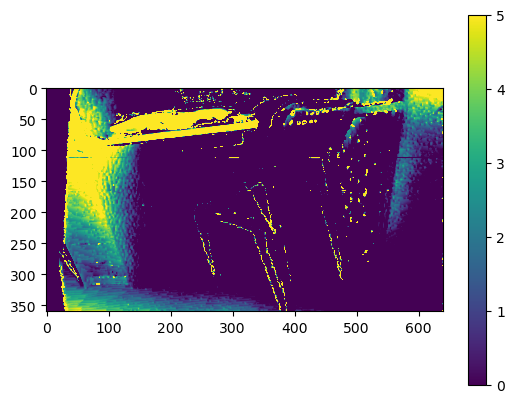

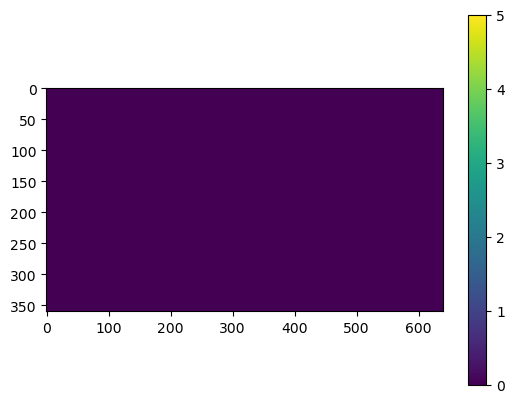

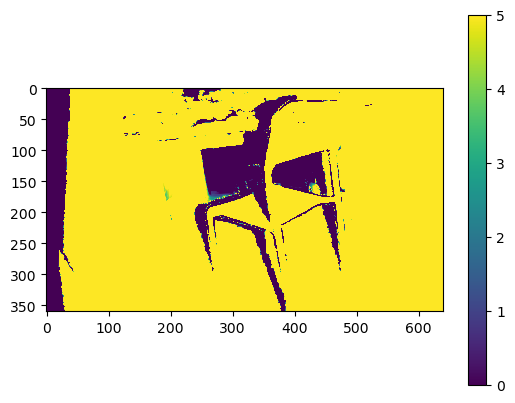

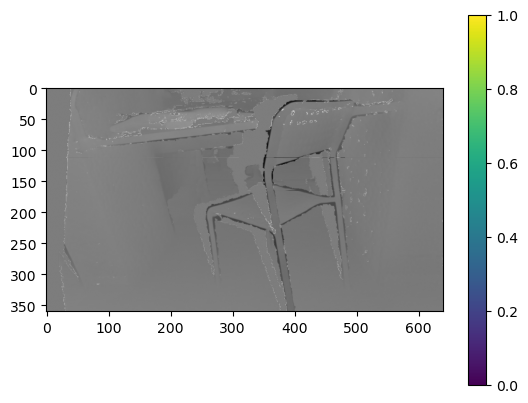

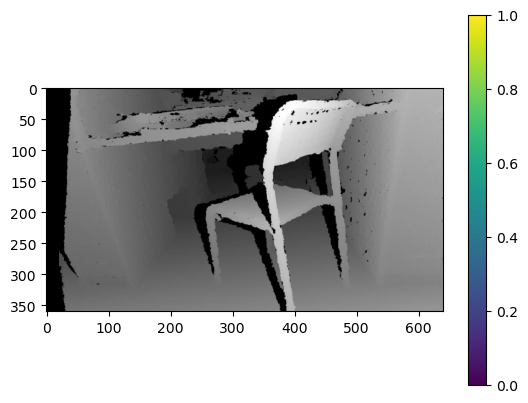

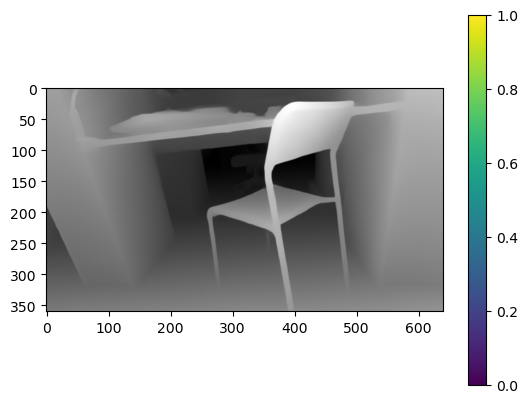

In [7]:
figure_show(diff_ot_agg, 1, 0, 5)
figure_show(diff_guilded_agg, 2, 0, 5)
figure_show(diff_dl_agg, 3, 0, 5)

figure_show(cm_diff_ot_agg, 4)
figure_show(cm_scaled_agg, 5)
figure_show(cm_scaled_dl, 6)

In [8]:
print(np.mean(diff_ot_agg))
print(np.mean(diff_guilded_agg))
print(np.mean(diff_dl_agg))

-2.398406149162157
-58.6536167405903
41.70973973030077


In [9]:
recheck_ret = recheck(ret, scaled_agg, alpha=0.15, Ws=0.5, Wt=0.5)

===> rechecking is completed!


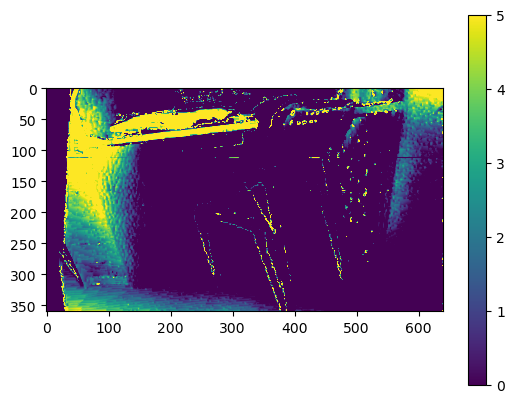

-1.4348240121427926


In [10]:
diff_recheck = recheck_ret - close_agg
figure_show(diff_recheck, 1, 0, 5)
print(np.mean(diff_recheck))

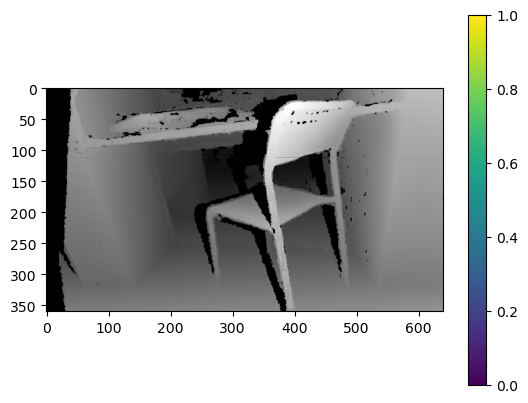

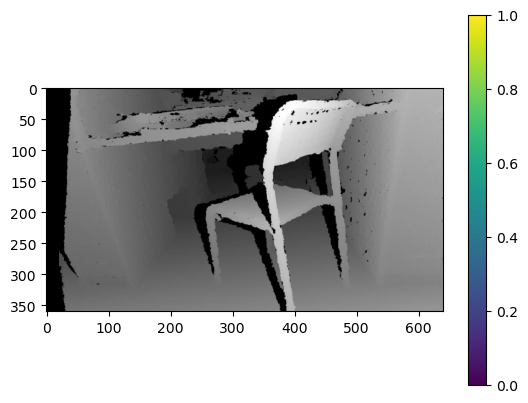

In [11]:
cm_recheck_ret = apply_colormap(recheck_ret)
cm_close_agg = apply_colormap(close_agg)
figure_show(cm_recheck_ret, 1)
figure_show(cm_close_agg, 2)

===> rechecking is completed!


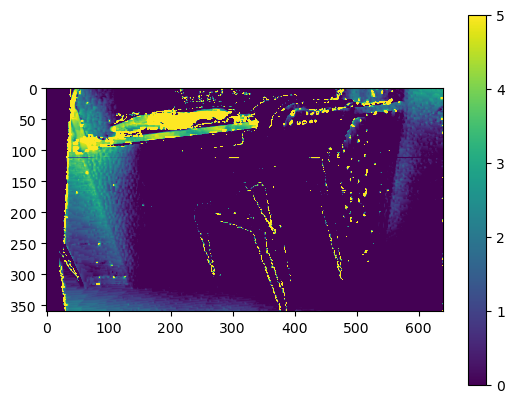

-2.162907468714497


/var/folders/h9/ylw6m9b51hv5f2rn_wywkdl00000gn/T/ipykernel_16875/3699217075.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


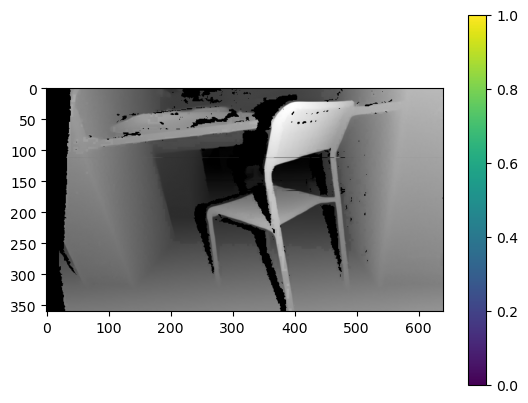

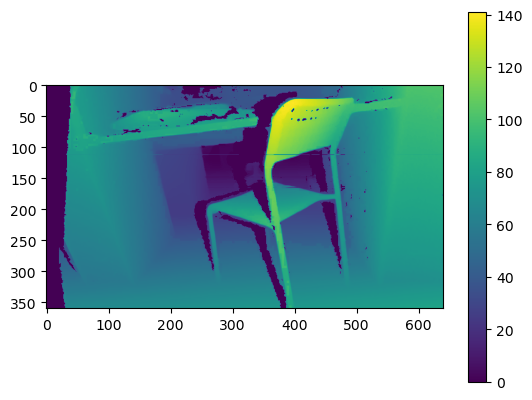

In [21]:
recheck_ret_vec = recheck_vectorized(ret, scaled_agg, alpha=0.15)
diff_recheck_vec = recheck_ret_vec - close_agg
figure_show(diff_recheck_vec, 1, 0, 5)
print(np.mean(diff_recheck_vec))

cm_recheck_ret_vec = apply_colormap(recheck_ret_vec)
figure_show(cm_recheck_ret_vec, 2)
figure_show(recheck_ret_vec, 3)

In [6]:
# resize the source and target image for computation efficiency
full_agg = np.load('data/11/output_0222_agg.npy')
full_dl = np.load('data/11/output_0626_DLV2.npy')
scaled_agg = image_resize(full_agg, (full_agg.shape[0]//2, full_agg.shape[1]//2))
scaled_dl = image_resize(full_dl, (full_dl.shape[0]//2, full_dl.shape[1]//2))

# close_agg = op_area_closing(scaled_agg, 64, 1)
close_agg = scaled_agg

# find the invalid pixels, and apply on dl result
insufficient_indices = np.where(scaled_agg <= 10)
dl = np.copy(scaled_dl)
dl[insufficient_indices] = 0

# normalize the distribution for both agg and dl result
# for the scale shift invariant
norm_agg = distribution_normalize(close_agg)
norm_dl = distribution_normalize(dl)

# calculate the mean and standard deviation for both agg and dl result
mu_agg = np.mean(norm_agg)
sigma_agg = np.std(norm_agg)
mu_dl = np.mean(norm_dl)
sigma_dl = np.std(norm_dl)

ret = build_pipeline(Xagg=scaled_agg, Xdl=scaled_dl)

guilded_ret = build_guided_filter(Xs=norm_agg, Xt=norm_dl)

In [13]:
# restore_ot_agg = restore_from_normal(ret, mu_agg, sigma_agg)
restore_guilded_agg = restore_from_normal(guilded_ret, mu_agg, sigma_agg)

diff_ot_agg = ret - close_agg
diff_guilded_agg = restore_guilded_agg - close_agg
diff_dl_agg = dl - close_agg

cm_diff_ot_agg = apply_colormap(diff_ot_agg)
cm_diff_guilded_agg = apply_colormap(diff_guilded_agg)
cm_diff_dl_agg = apply_colormap(diff_dl_agg)
cm_scaled_agg = apply_colormap(close_agg)
cm_scaled_dl = apply_colormap(scaled_dl)
cm_dl = apply_colormap(dl)

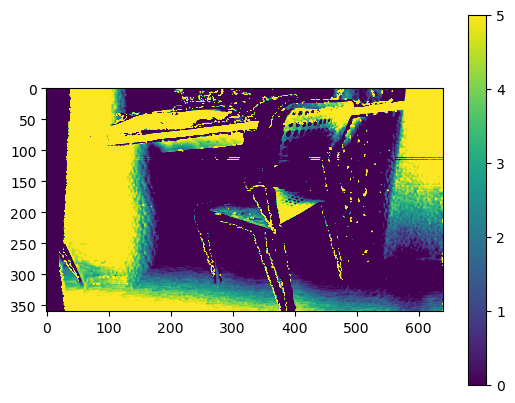

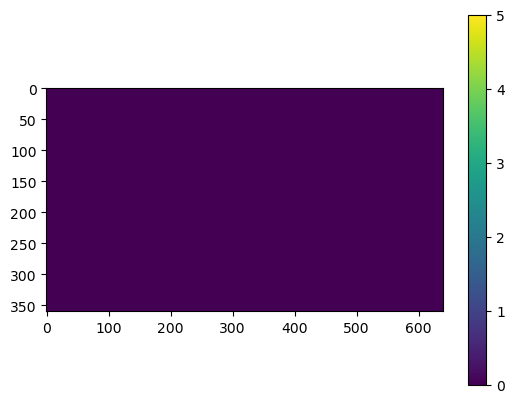

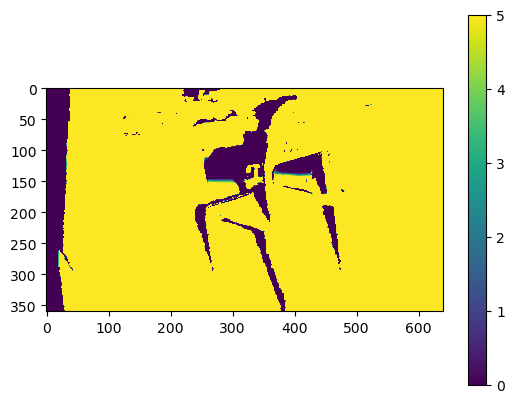

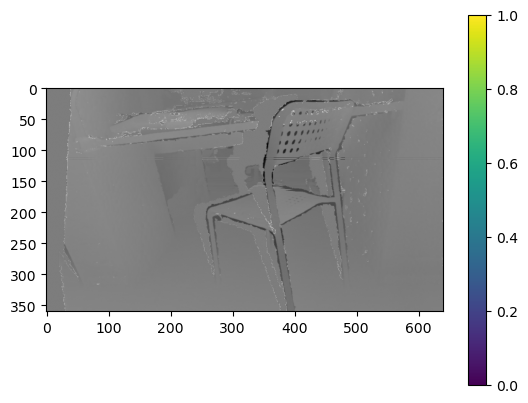

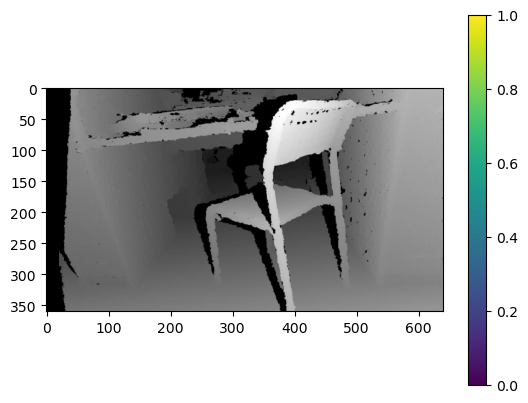

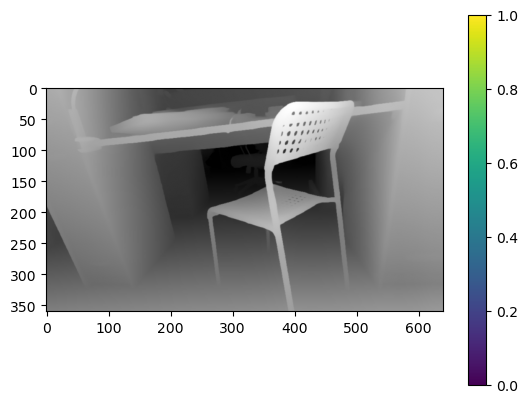

In [14]:
figure_show(diff_ot_agg, 1, 0, 5)
figure_show(diff_guilded_agg, 2, 0, 5)
figure_show(diff_dl_agg, 3, 0, 5)

figure_show(cm_diff_ot_agg, 4)
figure_show(cm_scaled_agg, 5)
figure_show(cm_scaled_dl, 6)

In [16]:
recheck_ret = recheck(ret, scaled_agg, alpha=0.15, Ws=0.5, Wt=0.5)

===> rechecking is completed!


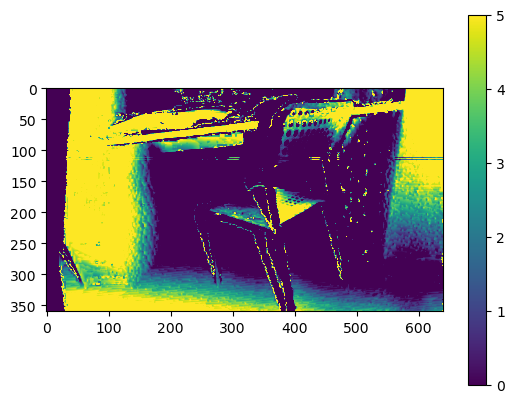

0.578549175138137


In [17]:
diff_recheck = recheck_ret - close_agg
figure_show(diff_recheck, 1, 0, 5)
print(np.mean(diff_recheck))

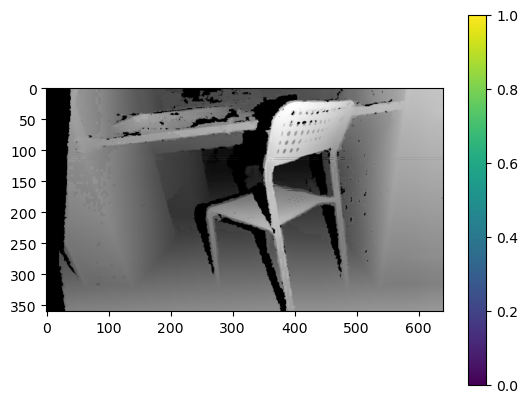

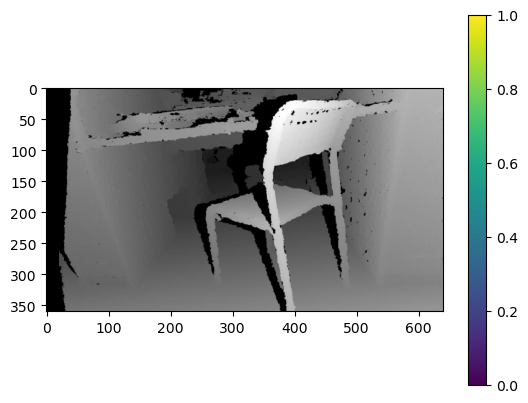

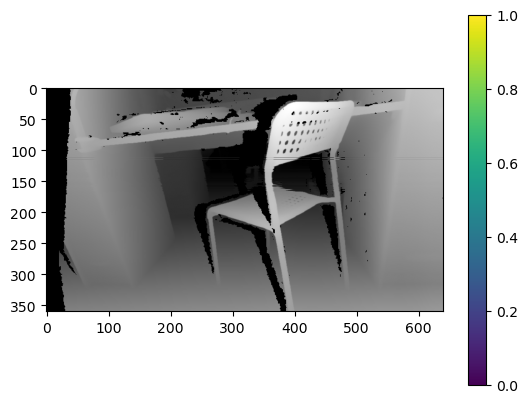

In [19]:
cm_recheck_ret = apply_colormap(recheck_ret)
cm_close_agg = apply_colormap(close_agg)
cm_ret = apply_colormap(ret)
figure_show(cm_recheck_ret, 1)
figure_show(cm_close_agg, 2)
figure_show(cm_ret, 3)

In [24]:
norm_agg, minv_agg, maxv_agg = minmax_normalizer(scaled_agg)
norm_dl, minv_dl, maxv_dl = minmax_normalizer(dl)

It.  |Loss        |Delta loss
--------------------------------
    0|1.063040e+03|0.000000e+00
    1|1.063040e+03|0.000000e+00


/var/folders/h9/ylw6m9b51hv5f2rn_wywkdl00000gn/T/ipykernel_16875/3699217075.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


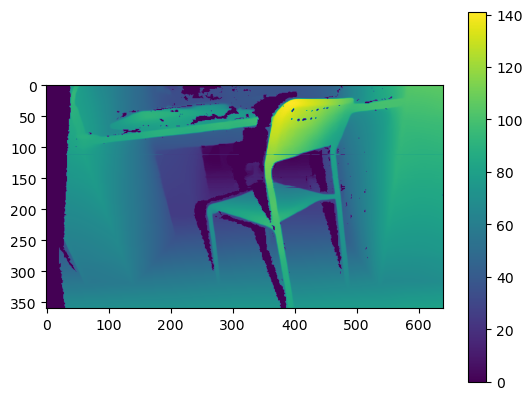

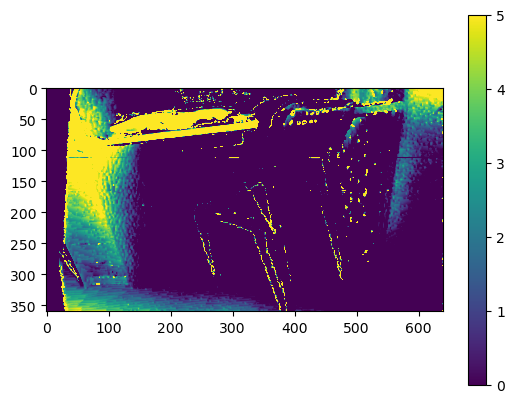

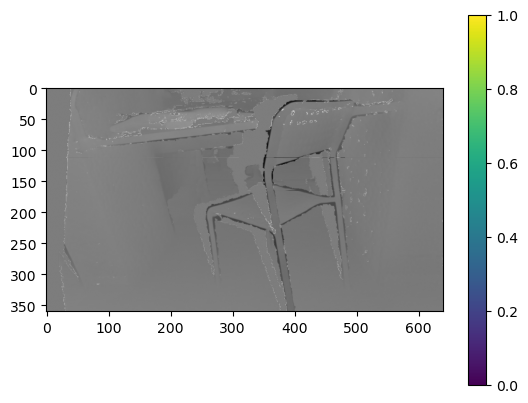

-2.398406149162157


In [27]:
ret_linear_ = ot_transport_mapping_linear(Xs=norm_agg, Xt=norm_dl)
ret_linear = restore_from_minmax(ret_linear_, minv_agg, maxv_agg)

diff_ot_linear = ret_linear - close_agg

cm_diff_ot_linear = apply_colormap(diff_ot_linear)

figure_show(ret_linear, 1)
figure_show(diff_ot_linear, 2, 0, 5)
figure_show(cm_diff_ot_linear, 3)

print(np.mean(diff_ot_linear))


It.  |Loss        |Delta loss
--------------------------------
    0|1.063330e+02|0.000000e+00
    1|1.063330e+02|-2.333809e-10


/var/folders/h9/ylw6m9b51hv5f2rn_wywkdl00000gn/T/ipykernel_16875/3699217075.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


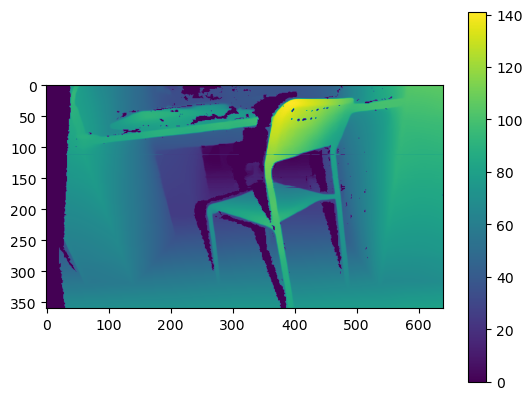

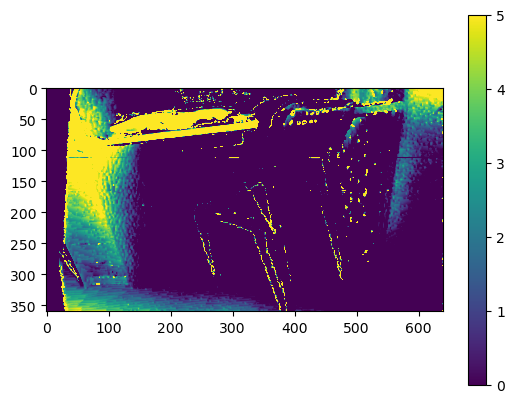

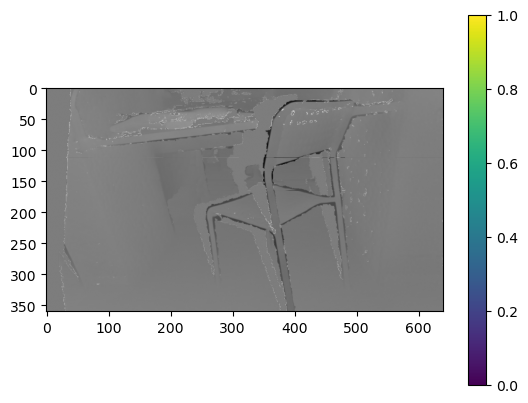

-2.398406149162157


In [26]:
ret_gauss_ = ot_transport_mapping_gaussian(Xs=norm_agg, Xt=norm_dl)
ret_gauss = restore_from_minmax(ret_linear_, minv_agg, maxv_agg)

diff_ot_gauss = ret_gauss - close_agg

cm_diff_ot_gauss = apply_colormap(diff_ot_gauss)

figure_show(ret_gauss, 1)
figure_show(diff_ot_gauss, 2, 0, 5)
figure_show(cm_diff_ot_gauss, 3)

print(np.mean(diff_ot_gauss))

In [11]:
# resize the source and target image for computation efficiency
full_agg = np.load('data/11/output_0222_agg.npy')
full_dl = np.load('data/11/output_0222_DL.npy')
scaled_agg = image_resize(full_agg, (full_agg.shape[0]//2, full_agg.shape[1]//2))
scaled_dl = image_resize(full_dl, (full_dl.shape[0]//2, full_dl.shape[1]//2))

# close_agg = op_area_closing(scaled_agg, 64, 1)
close_agg = scaled_agg

# find the invalid pixels, and apply on dl result
insufficient_indices = np.where(scaled_agg <= 10)
dl = np.copy(scaled_dl)
dl[insufficient_indices] = 0

# normalize the distribution for both agg and dl result
# for the scale shift invariant
# norm_agg = distribution_normalize(close_agg)
# norm_dl = distribution_normalize(dl)

norm_agg2 = distribution_minmax(close_agg)
norm_dl2 = distribution_minmax(dl)

minv_agg = np.min(close_agg)
maxv_agg = np.max(close_agg)
minv_dl = np.min(dl)
maxv_dl = np.max(dl)


ret2 = build_pipeline(Xagg=scaled_agg, Xdl=scaled_dl)

guilded_ret2 = build_guided_filter(Xs=norm_agg2, Xt=norm_dl2)

In [12]:
# restore_ot_agg = restore_from_normal(ret, mu_agg, sigma_agg)
restore_guilded_agg2 = restore_from_minmax(guilded_ret2, minv_agg, maxv_agg)

diff_ot_agg2 = ret2 - close_agg
diff_guilded_agg2 = restore_guilded_agg2 - close_agg
diff_dl_agg2 = diff_guilded_agg2 - close_agg

cm_diff_ot_agg2 = apply_colormap(diff_ot_agg2)
cm_diff_guilded_agg2 = apply_colormap(diff_guilded_agg2)
cm_diff_dl_agg2 = apply_colormap(diff_dl_agg2)

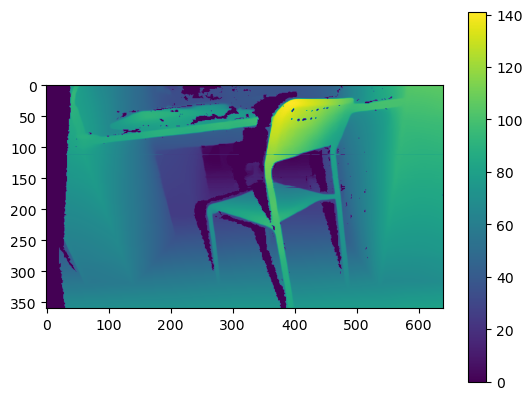

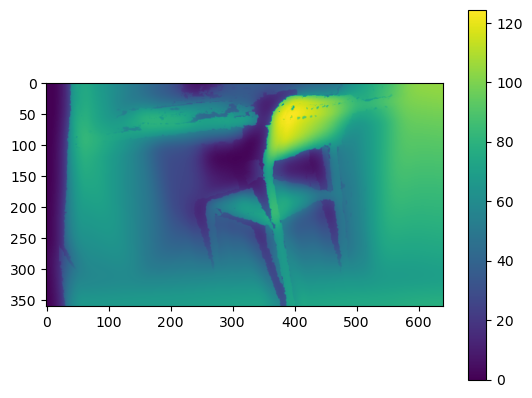

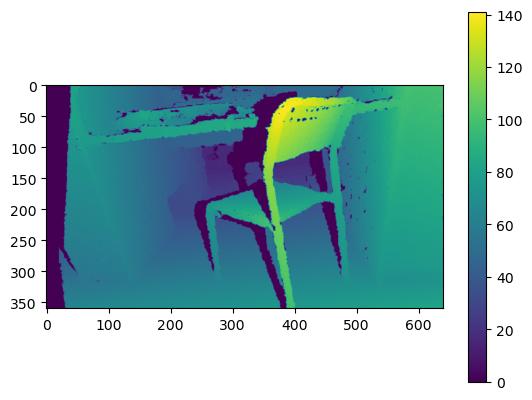

In [13]:
figure_show(ret2, 1)
figure_show(restore_guilded_agg2, 2)
figure_show(close_agg, 3)

In [15]:
print(np.mean(diff_ot_agg2))
print(np.mean(diff_guilded_agg2))
print(np.mean(diff_dl_agg2))

-2.398406149162157
-2.3984050374334216
-61.05202189599139


360 640


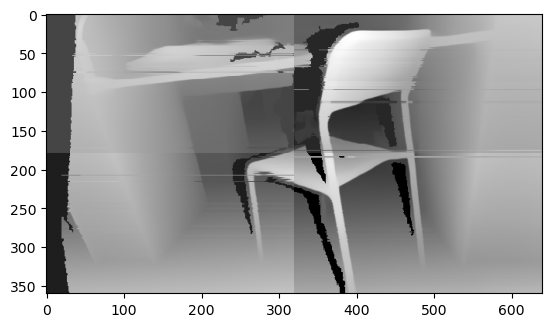

In [43]:
h, w = agg_norm.shape
print(h, w)

agg_norm_1 = agg_norm[:h//2, :w//2]
agg_norm_2 = agg_norm[:, w//2:]
agg_norm_3 = agg_norm[h//2:, :w//2]
agg_norm_4 = agg_norm[h//2:, w//2:]

dl_norm_1 = dl_norm[:h//2, :w//2]
dl_norm_2 = dl_norm[:, w//2:]
dl_norm_3 = dl_norm[h//2:, :w//2]
dl_norm_4 = dl_norm[h//2:, w//2:]

# test on segmentation
agg_norm_datasets = [agg_norm_1, agg_norm_2, agg_norm_3, agg_norm_4]
dl_norm_datasets = [dl_norm_1, dl_norm_2, dl_norm_3, dl_norm_4]

res = []
for agg, dl in zip(agg_norm_datasets, dl_norm_datasets):
    ret = build_pipeline(agg, dl)
    res.append(ret)

agg_ret = np.zeros_like(agg_norm)
agg_ret[:h//2, :w//2] = res[0]
agg_ret[:, w//2:] = res[1]
agg_ret[h//2:, :w//2] = res[2]
agg_ret[h//2:, w//2:] = res[3]

cm_agg_ret = apply_colormap(agg_ret)
figure_show(cm_agg_ret)

360 640


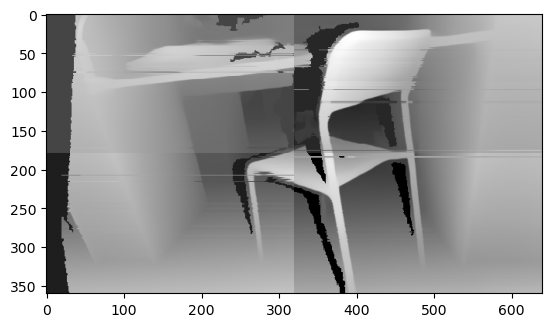

In [52]:
h, w = close_agg.shape
print(h, w)

agg_norm_1 = close_agg[:h//2, :w//2]
agg_norm_2 = close_agg[:, w//2:]
agg_norm_3 = close_agg[h//2:, :w//2]
agg_norm_4 = close_agg[h//2:, w//2:]

dl_norm_1 = dl[:h//2, :w//2]
dl_norm_2 = dl[:, w//2:]
dl_norm_3 = dl[h//2:, :w//2]
dl_norm_4 = dl[h//2:, w//2:]

agg_norm_1 = distribution_normalize(agg_norm_1)
agg_norm_2 = distribution_normalize(agg_norm_2)
agg_norm_3 = distribution_normalize(agg_norm_3)
agg_norm_4 = distribution_normalize(agg_norm_4)

dl_norm_1 = distribution_normalize(dl_norm_1)
dl_norm_1 = distribution_normalize(dl_norm_1)
dl_norm_1 = distribution_normalize(dl_norm_1)
dl_norm_1 = distribution_normalize(dl_norm_1)


# test on segmentation
agg_norm_datasets = [agg_norm_1, agg_norm_2, agg_norm_3, agg_norm_4]
dl_norm_datasets = [dl_norm_1, dl_norm_2, dl_norm_3, dl_norm_4]

res = []
for agg, dl in zip(agg_norm_datasets, dl_norm_datasets):
    ret = build_pipeline(agg, dl)
    res.append(ret)

agg_ret = np.zeros_like(close_agg)
agg_ret[:h//2, :w//2] = res[0]
agg_ret[:, w//2:] = res[1]
agg_ret[h//2:, :w//2] = res[2]
agg_ret[h//2:, w//2:] = res[3]

cm_agg_ret = apply_colormap(agg_ret)
figure_show(cm_agg_ret)

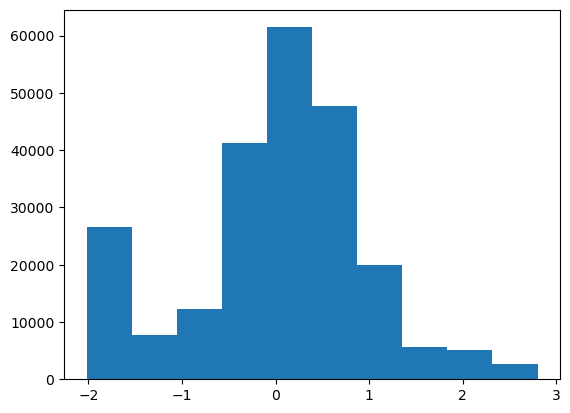

In [19]:
plt.figure()
plt.hist(agg_norm.flatten())
plt.show()

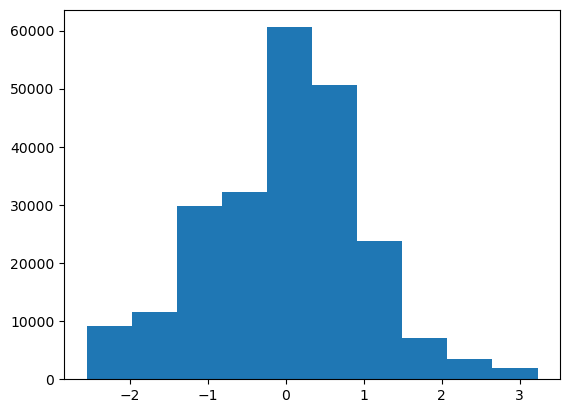

In [20]:
plt.figure()
plt.hist(dl_norm.flatten())
plt.show()

In [126]:
import ot
import matplotlib.pylab as pl
import matplotlib.animation as animation


# Cost matrix
M = ot.dist(agg_norm, dl_norm, metric='sqeuclidean')

ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=agg_norm, Xt=dl_norm)

transp_Xs_emd = ot_emd.transform(Xs=agg_norm)

# Sinkhorn Transport
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
ot_sinkhorn.fit(Xs=agg_norm, Xt=dl_norm)

transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=agg_norm)

# # Sinkhorn Transport with Group lasso regularization
# ot_lpl1 = ot.da.SinkhornLpl1Transport(reg_e=1e-1, reg_cl=1e0)
# ot_lpl1.fit(Xs=agg_norm, Xt=dl_norm)

# laplacian regularization
ot_emd_laplace = ot.da.EMDLaplaceTransport(reg_lap=100, reg_src=1, similarity='gauss')
ot_emd_laplace.fit(Xs=agg_norm, Xt=dl_norm)

transp_Xs_laplace = ot_emd_laplace.transform(Xs=agg_norm)


/algdata01/wei.wei/anaconda3/envs/zoe/lib/python3.9/site-packages/ot/bregman/_sinkhorn.py:498: RuntimeWarning: divide by zero encountered in divide
  v = b / KtransposeU
/algdata01/wei.wei/anaconda3/envs/zoe/lib/python3.9/site-packages/ot/bregman/_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/algdata01/wei.wei/anaconda3/envs/zoe/lib/python3.9/site-packages/ot/da.py:595: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]


In [127]:
def ot_transport_laplace(Xs, Xt):
    ot_emd_laplace = ot.da.EMDLaplaceTransport(reg_lap=100, reg_src=1, similarity='gauss')
    ot_emd_laplace.fit(Xs=Xs, Xt=Xt)

    transp_Xs_laplace = ot_emd_laplace.transform(Xs=Xs)
    return transp_Xs_laplace

def restore_from_normal(arr, mu, sigma):
    return arr * sigma + mu

def restore_from_minmax(arr, minval, maxval):
    return arr * (maxval - minval) + minval

In [130]:
agg_restore_emd = transp_Xs_emd * np.std(close_agg) + np.mean(close_agg)
agg_restore_sinkhorn = transp_Xs_sinkhorn * np.std(close_agg) + np.mean(close_agg)
agg_restore_laplace = transp_Xs_laplace * np.std(close_agg) + np.mean(close_agg)
restore_filter_image = filter_image * np.std(close_agg) + np.mean(close_agg)

print(restore_filter_image.min(), restore_filter_image.max())
print(close_agg.min(), close_agg.max())
print(agg_restore_emd.min(), agg_restore_emd.max())
print(agg_restore_laplace.min(), agg_restore_laplace.max())

In [129]:
# Cost matrix
M = ot.dist(agg_minmax, dl_minmax, metric='sqeuclidean')

ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=agg_minmax, Xt=dl_minmax)

transp_Xs_emd = ot_emd.transform(Xs=agg_minmax)

# Sinkhorn Transport
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
ot_sinkhorn.fit(Xs=agg_minmax, Xt=dl_minmax)

transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=agg_norm)

# # Sinkhorn Transport with Group lasso regularization
# ot_lpl1 = ot.da.SinkhornLpl1Transport(reg_e=1e-1, reg_cl=1e0)
# ot_lpl1.fit(Xs=agg_norm, Xt=dl_minmax)

# laplacian regularization
ot_emd_laplace = ot.da.EMDLaplaceTransport(reg_lap=100, reg_src=1)
ot_emd_laplace.fit(Xs=agg_minmax, Xt=dl_minmax)

transp_Xs_laplace = ot_emd_laplace.transform(Xs=agg_minmax)

/algdata01/wei.wei/anaconda3/envs/zoe/lib/python3.9/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8002f71160>
Traceback (most recent call last):
  File "/algdata01/wei.wei/anaconda3/envs/zoe/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/algdata01/wei.wei/anaconda3/envs/zoe/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/algdata01/wei.wei/anaconda3/envs/zoe/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.versi

In [131]:
agg_restore_emd = transp_Xs_emd * (np.max(close_agg) - np.min(close_agg)) + np.min(close_agg)
agg_restore_sinkhorn = transp_Xs_sinkhorn * (np.max(close_agg) - np.min(close_agg)) + np.min(close_agg)
agg_restore_laplace = transp_Xs_laplace * (np.max(close_agg) - np.min(close_agg)) + np.min(close_agg)

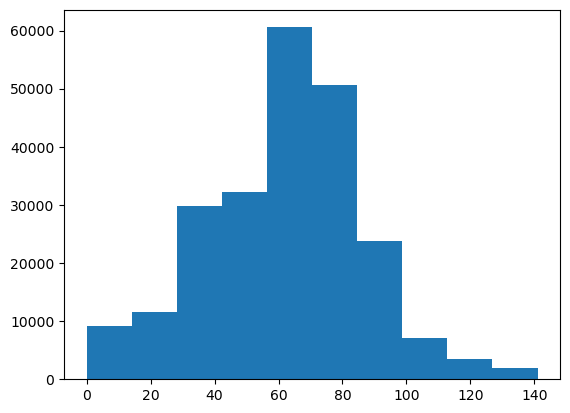

In [132]:
plt.figure()
plt.hist(agg_restore_emd.flatten())
plt.show()

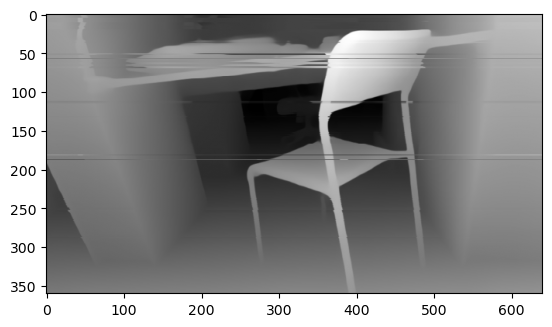

In [133]:
cm_agg_restore_emd = apply_colormap(agg_restore_emd)
figure_show(cm_agg_restore_emd)

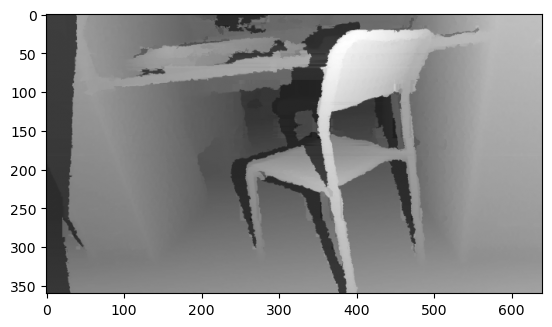

In [134]:
cm_agg_restore_sinkhorn = apply_colormap(agg_restore_sinkhorn)
figure_show(cm_agg_restore_sinkhorn)

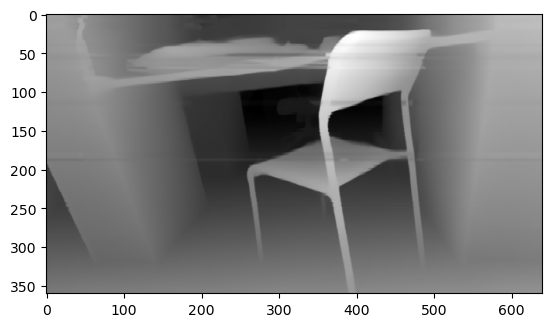

In [135]:
cm_agg_restore_laplace = apply_colormap(agg_restore_laplace)
figure_show(cm_agg_restore_laplace)

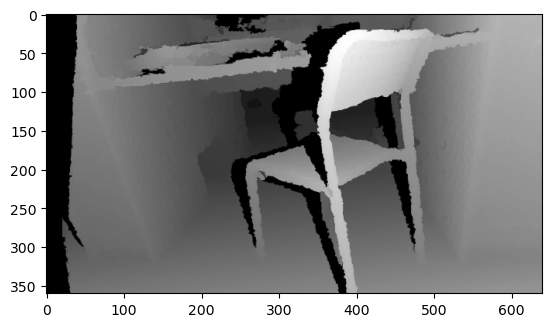

In [136]:
figure_show(cm_close_agg)

In [137]:
agg_restore_emd

array([[ 87.97904944,  87.90923536,  88.15722789, ..., 105.7153565 ,
        105.6708476 , 104.84867688],
       [ 88.37553662,  88.09738124,  88.24748951, ..., 105.86140551,
        105.5835863 ,  94.65787129],
       [ 87.77372527,  87.78828143,  87.77539772, ..., 105.17680391,
        105.26432575, 105.39626403],
       ...,
       [ 66.38755859,  66.36118186,  66.39729491, ...,  80.3686924 ,
         80.42393352,  80.49808419],
       [ 66.64110633,  66.65427999,  66.70662585, ...,  80.62403865,
         80.73782376,  80.9227088 ],
       [ 66.70304564,  66.9510886 ,  67.01068732, ...,  80.89504201,
         81.05721878,  80.92309539]])

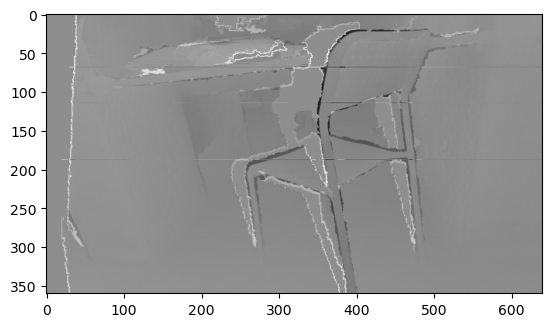

-133.10152718942226 105.51397854057006


In [116]:
diff = agg_restore_emd-close_agg
cm_diff = apply_colormap(diff)
figure_show(cm_diff)

print(diff.min(), diff.max())

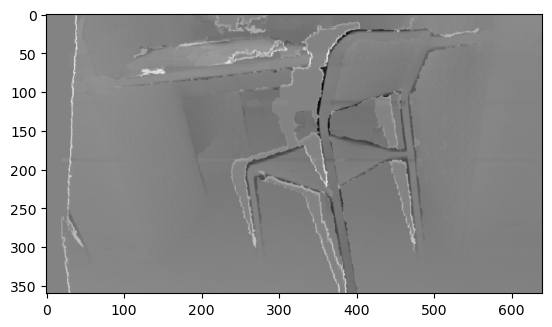

-110.83960719094208 103.5397892926718


In [74]:
diff = agg_restore_laplace-close_agg
cm_diff = apply_colormap(diff)
figure_show(cm_diff)

print(diff.min(), diff.max())

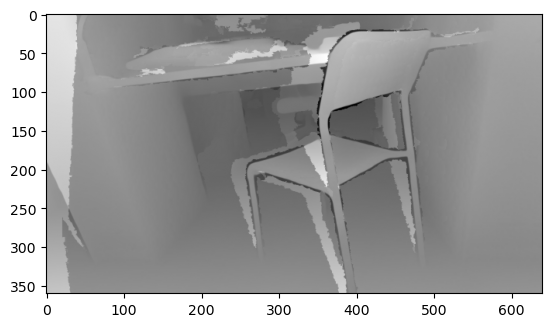

-109.65752870850062 187.89543477224407


In [67]:
diff = disp_dl_scaled-close_agg
cm_diff = apply_colormap(diff)
figure_show(cm_diff)

print(diff.min(), diff.max())

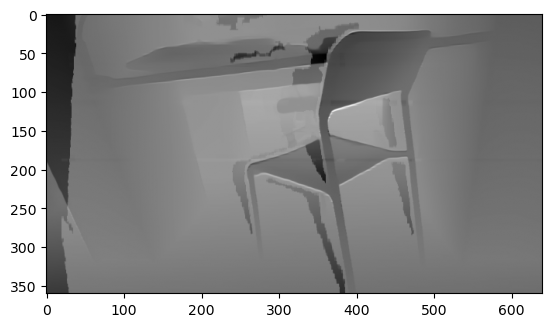

-183.25946381849587 94.47502997540369


In [75]:
diff = agg_restore_laplace-disp_dl_scaled
cm_diff = apply_colormap(diff)
figure_show(cm_diff)

print(diff.min(), diff.max())

In [6]:
# normalize the matrix to [0, 1]
disp_dl_scaled_norm = (disp_dl_scaled - disp_dl_scaled.min()) / (disp_dl_scaled.max()-disp_dl_scaled.min())
disp_dl_scaled_norm

array([[0.6267774 , 0.6248047 , 0.6258693 , ..., 0.7507908 , 0.7488204 ,
        0.671333  ],
       [0.62396544, 0.6234703 , 0.6252291 , ..., 0.74975497, 0.7494393 ,
        0.7436083 ],
       [0.6258023 , 0.6249049 , 0.62485594, ..., 0.74960077, 0.7494203 ,
        0.74994105],
       ...,
       [0.47263238, 0.4727258 , 0.47309706, ..., 0.5718022 , 0.5726092 ,
        0.5739204 ],
       [0.47307166, 0.47483084, 0.47525352, ..., 0.5737242 , 0.5748744 ,
        0.5739232 ],
       [0.44654322, 0.4752296 , 0.4772178 , ..., 0.57664335, 0.5760539 ,
        0.5532835 ]], dtype=float32)

In [8]:
disp_agg_scaled_norm = (disp_agg_scaled - disp_agg_scaled.min()) / (disp_agg_scaled.max()-disp_agg_scaled.min())
disp_agg_scaled_norm

array([[0.        , 0.        , 0.        , ..., 0.71221868, 0.71276565,
        0.71574277],
       [0.        , 0.        , 0.        , ..., 0.71063531, 0.70955951,
        0.71097428],
       [0.        , 0.        , 0.        , ..., 0.7092209 , 0.70922105,
        0.71080391],
       ...,
       [0.        , 0.        , 0.        , ..., 0.5815608 , 0.5815607 ,
        0.58122244],
       [0.        , 0.        , 0.        , ..., 0.5815608 , 0.58155675,
        0.56787389],
       [0.        , 0.        , 0.        , ..., 0.5815608 , 0.58152245,
        0.45175848]])

In [9]:
xx, yy = np.meshgrid(np.arange(disp_dl_scaled_norm.shape[1]), np.arange(disp_dl_scaled_norm.shape[0]))

In [10]:
dl_graph = np.dstack((yy, xx, disp_dl_scaled_norm))

In [11]:
agg_graph = np.dstack((yy, xx, disp_agg_scaled_norm))

In [12]:
agg_close = op_area_closing(disp_agg_scaled, 64, 1)

In [13]:
agg_close_graph = np.dstack((yy, xx, op_norm(agg_close)))

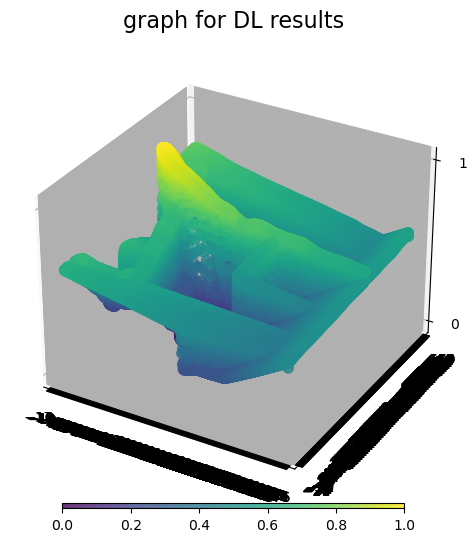

In [16]:
plot_3d(dl_graph, "graph for DL results")

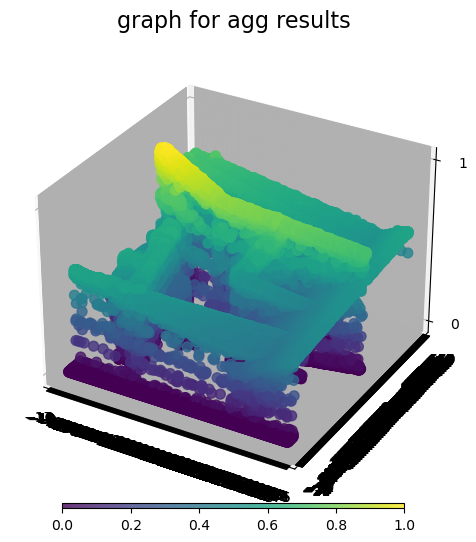

In [17]:
plot_3d(agg_graph, "graph for agg results")

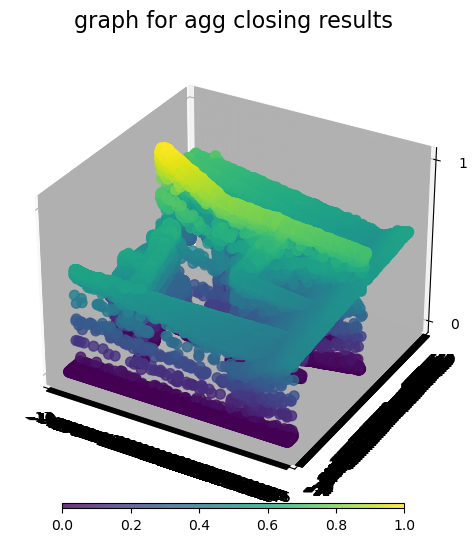

In [18]:
plot_3d(agg_close_graph, "graph for agg closing results")

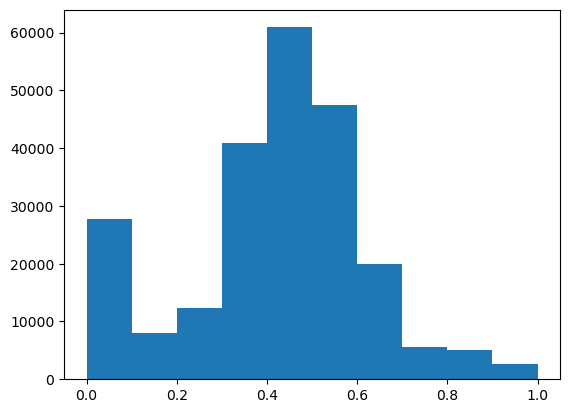

In [26]:
plt.figure()
plt.hist(disp_agg_scaled_norm.flatten())
plt.show()

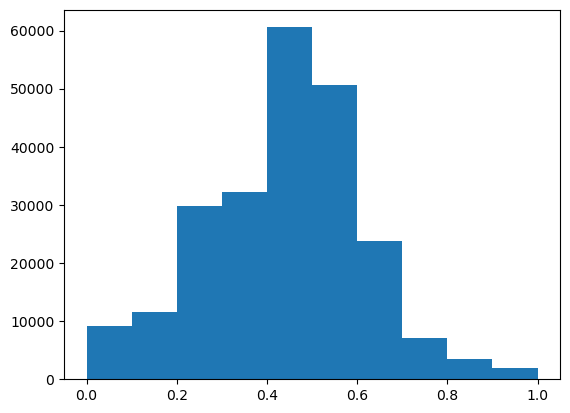

In [27]:
plt.figure()
plt.hist(disp_dl_scaled_norm.flatten())
plt.show()

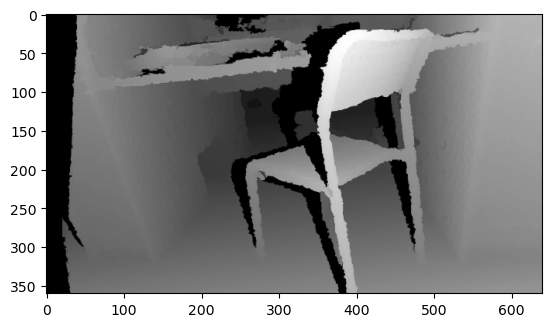

In [20]:
cm_agg_close = apply_colormap(agg_close)
plt.figure()
plt.imshow(cm_agg_close)

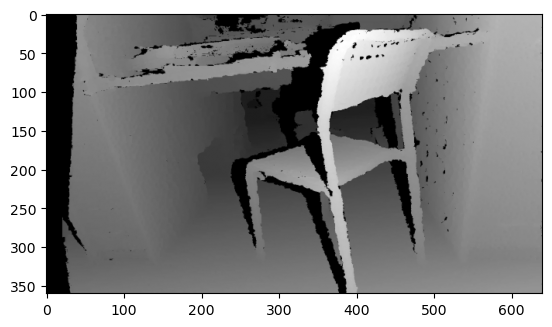

In [21]:
plt.figure()
cm_agg = apply_colormap(disp_agg_scaled)
plt.imshow(cm_agg)

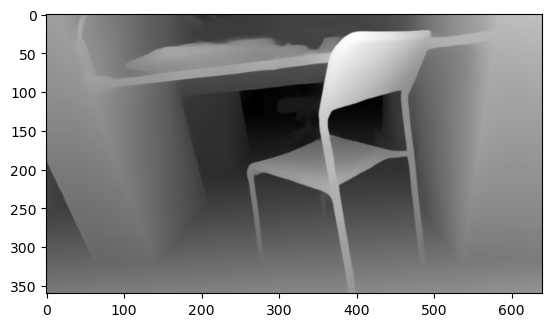

In [24]:
plt.figure()
cm_dl = apply_colormap(disp_dl_scaled)
plt.imshow(cm_dl)

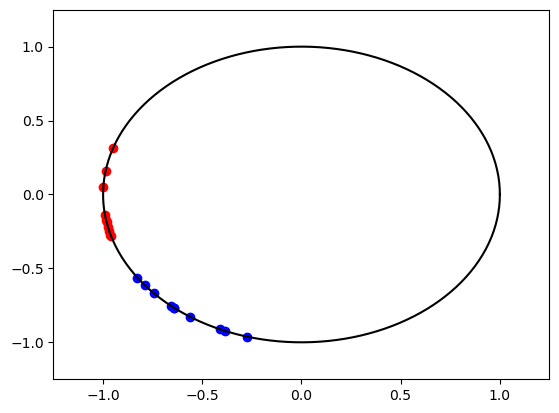

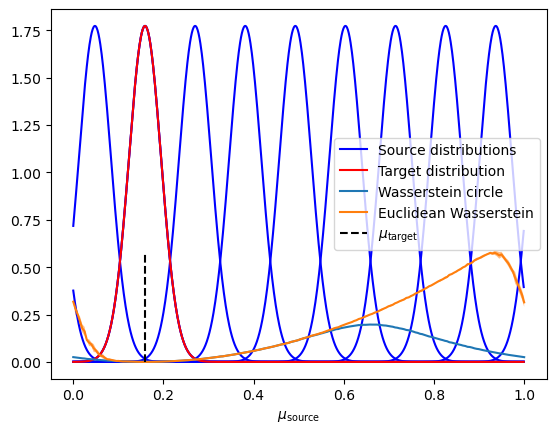

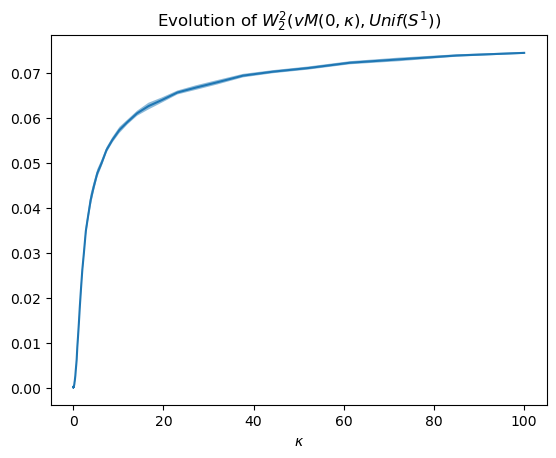

In [3]:
# -*- coding: utf-8 -*-
"""
=========================
OT distance on the Circle
=========================

Shows how to compute the Wasserstein distance on the circle


"""

# Author: Clément Bonet <clement.bonet@univ-ubs.fr>
#
# License: MIT License

# sphinx_gallery_thumbnail_number = 2

import numpy as np
import matplotlib.pylab as pl
import ot

from scipy.special import iv

##############################################################################
# Plot data
# ---------

#%% plot the distributions


def pdf_von_Mises(theta, mu, kappa):
    pdf = np.exp(kappa * np.cos(theta - mu)) / (2.0 * np.pi * iv(0, kappa))
    return pdf


t = np.linspace(0, 2 * np.pi, 1000, endpoint=False)

mu1 = 1
kappa1 = 20

mu_targets = np.linspace(mu1, mu1 + 2 * np.pi, 10)


pdf1 = pdf_von_Mises(t, mu1, kappa1)


pl.figure(1)
for k, mu in enumerate(mu_targets):
    pdf_t = pdf_von_Mises(t, mu, kappa1)
    if k == 0:
        label = "Source distributions"
    else:
        label = None
    pl.plot(t / (2 * np.pi), pdf_t, c='b', label=label)

pl.plot(t / (2 * np.pi), pdf1, c="r", label="Target distribution")
pl.legend()

mu2 = 0
kappa2 = kappa1

x1 = np.random.vonmises(mu1, kappa1, size=(10,)) + np.pi
x2 = np.random.vonmises(mu2, kappa2, size=(10,)) + np.pi

angles = np.linspace(0, 2 * np.pi, 150)

pl.figure(2)
pl.plot(np.cos(angles), np.sin(angles), c="k")
pl.xlim(-1.25, 1.25)
pl.ylim(-1.25, 1.25)
pl.scatter(np.cos(x1), np.sin(x1), c="b")
pl.scatter(np.cos(x2), np.sin(x2), c="r")

#########################################################################################
# Compare the Euclidean Wasserstein distance with the Wasserstein distance on the  circle
# ---------------------------------------------------------------------------------------
# This examples illustrates the periodicity of the Wasserstein distance on the circle.
# We choose as target distribution a von Mises distribution with mean :math:`\mu_{\mathrm{target}}`
# and :math:`\kappa=20`. Then, we compare the distances with samples obtained from a von Mises distribution
# with parameters :math:`\mu_{\mathrm{source}}` and :math:`\kappa=20`.
# The Wasserstein distance on the circle takes into account the periodicity
# and attains its maximum in :math:`\mu_{\mathrm{target}}+1` (the antipodal point) contrary to the
# Euclidean version.

#%% Compute and plot distributions

mu_targets = np.linspace(0, 2 * np.pi, 200)
xs = np.random.vonmises(mu1 - np.pi, kappa1, size=(500,)) + np.pi

n_try = 5

xts = np.zeros((n_try, 200, 500))
for i in range(n_try):
    for k, mu in enumerate(mu_targets):
        # np.random.vonmises deals with data on [-pi, pi[
        xt = np.random.vonmises(mu - np.pi, kappa2, size=(500,)) + np.pi
        xts[i, k] = xt

# Put data on S^1=[0,1[
xts2 = xts / (2 * np.pi)
xs2 = np.concatenate([xs[None] for k in range(200)], axis=0) / (2 * np.pi)

L_w2_circle = np.zeros((n_try, 200))
L_w2 = np.zeros((n_try, 200))

for i in range(n_try):
    w2_circle = ot.wasserstein_circle(xs2.T, xts2[i].T, p=2)
    w2 = ot.wasserstein_1d(xs2.T, xts2[i].T, p=2)

    L_w2_circle[i] = w2_circle
    L_w2[i] = w2

m_w2_circle = np.mean(L_w2_circle, axis=0)
std_w2_circle = np.std(L_w2_circle, axis=0)

m_w2 = np.mean(L_w2, axis=0)
std_w2 = np.std(L_w2, axis=0)

pl.figure(1)
pl.plot(mu_targets / (2 * np.pi), m_w2_circle, label="Wasserstein circle")
pl.fill_between(mu_targets / (2 * np.pi), m_w2_circle - 2 * std_w2_circle, m_w2_circle + 2 * std_w2_circle, alpha=0.5)
pl.plot(mu_targets / (2 * np.pi), m_w2, label="Euclidean Wasserstein")
pl.fill_between(mu_targets / (2 * np.pi), m_w2 - 2 * std_w2, m_w2 + 2 * std_w2, alpha=0.5)
pl.vlines(x=[mu1 / (2 * np.pi)], ymin=0, ymax=np.max(w2), linestyle="--", color="k", label=r"$\mu_{\mathrm{target}}$")
pl.legend()
pl.xlabel(r"$\mu_{\mathrm{source}}$")
pl.show()


########################################################################
# Wasserstein distance between von Mises and uniform for different kappa
# ----------------------------------------------------------------------
# When :math:`\kappa=0`, the von Mises distribution is the uniform distribution on :math:`S^1`.

#%% Compute Wasserstein between Von Mises and uniform

kappas = np.logspace(-5, 2, 100)
n_try = 20

xts = np.zeros((n_try, 100, 500))
for i in range(n_try):
    for k, kappa in enumerate(kappas):
        # np.random.vonmises deals with data on [-pi, pi[
        xt = np.random.vonmises(0, kappa, size=(500,)) + np.pi
        xts[i, k] = xt / (2 * np.pi)

L_w2 = np.zeros((n_try, 100))
for i in range(n_try):
    L_w2[i] = ot.semidiscrete_wasserstein2_unif_circle(xts[i].T)

m_w2 = np.mean(L_w2, axis=0)
std_w2 = np.std(L_w2, axis=0)

pl.figure(1)
pl.plot(kappas, m_w2)
pl.fill_between(kappas, m_w2 - std_w2, m_w2 + std_w2, alpha=0.5)
pl.title(r"Evolution of $W_2^2(vM(0,\kappa), Unif(S^1))$")
pl.xlabel(r"$\kappa$")
pl.show()

# %%

It.  |Err         
-------------------
    0|2.861463e-01|
   10|1.860154e-01|
   20|8.144529e-02|
   30|3.130143e-02|
   40|1.178815e-02|
   50|4.426078e-03|
   60|1.661047e-03|
   70|6.233110e-04|
   80|2.338932e-04|
   90|8.776627e-05|
  100|3.293340e-05|
  110|1.235791e-05|
  120|4.637176e-06|
  130|1.740051e-06|
  140|6.529356e-07|
  150|2.450071e-07|
  160|9.193632e-08|
  170|3.449812e-08|
  180|1.294505e-08|
  190|4.857493e-09|
It.  |Err         
-------------------
  200|1.822723e-09|


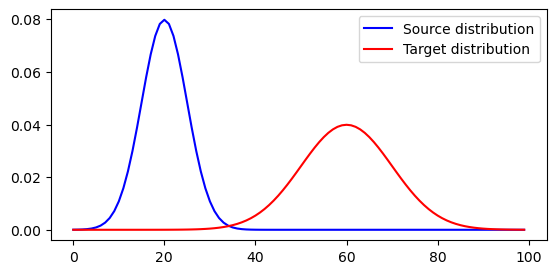

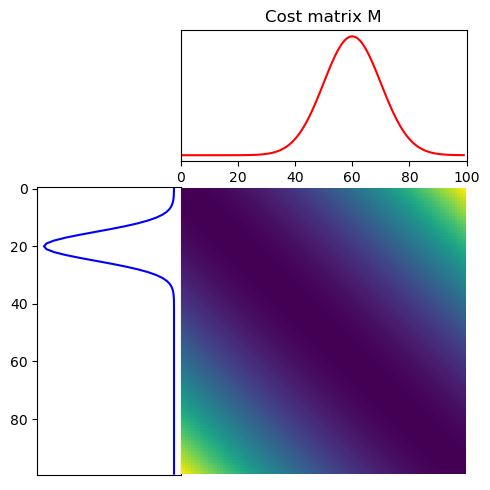

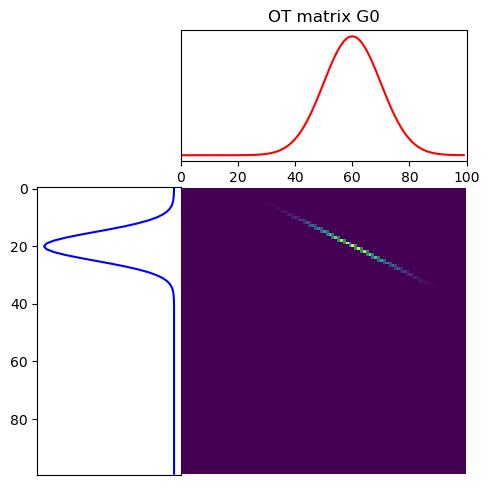

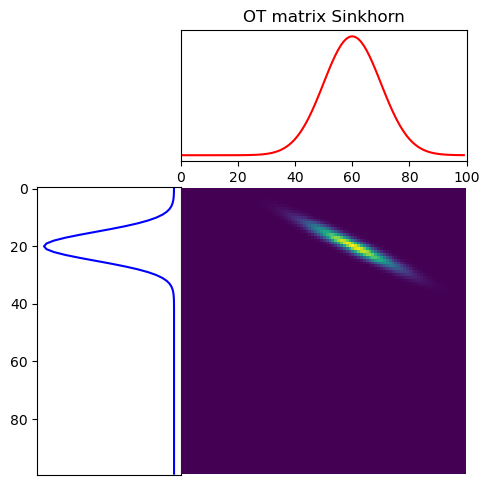

In [4]:
# -*- coding: utf-8 -*-
"""
======================================
Optimal Transport for 1D distributions
======================================

This example illustrates the computation of EMD and Sinkhorn transport plans
and their visualization.

"""

# Author: Remi Flamary <remi.flamary@unice.fr>
#
# License: MIT License
# sphinx_gallery_thumbnail_number = 3

import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss

##############################################################################
# Generate data
# -------------


#%% parameters

n = 100  # nb bins

# bin positions
x = np.arange(n, dtype=np.float64)

# Gaussian distributions
a = gauss(n, m=20, s=5)  # m= mean, s= std
b = gauss(n, m=60, s=10)

# loss matrix
M = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
M /= M.max()


##############################################################################
# Plot distributions and loss matrix
# ----------------------------------

#%% plot the distributions

pl.figure(1, figsize=(6.4, 3))
pl.plot(x, a, 'b', label='Source distribution')
pl.plot(x, b, 'r', label='Target distribution')
pl.legend()

#%% plot distributions and loss matrix

pl.figure(2, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, M, 'Cost matrix M')

##############################################################################
# Solve EMD
# ---------


#%% EMD

# use fast 1D solver
G0 = ot.emd_1d(x, x, a, b)

# Equivalent to
# G0 = ot.emd(a, b, M)

pl.figure(3, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, G0, 'OT matrix G0')

##############################################################################
# Solve Sinkhorn
# --------------


#%% Sinkhorn

lambd = 1e-3
Gs = ot.sinkhorn(a, b, M, lambd, verbose=True)

pl.figure(4, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, Gs, 'OT matrix Sinkhorn')

pl.show()

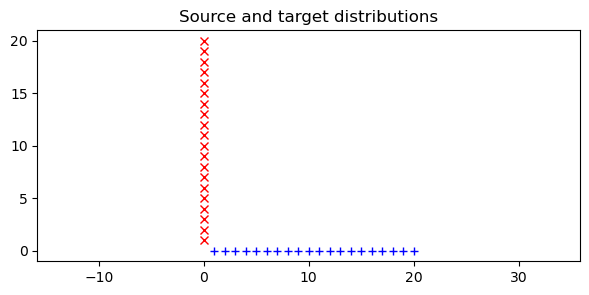

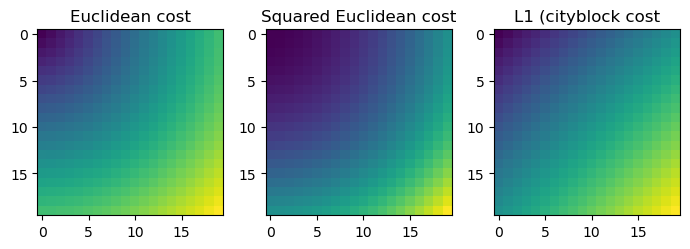

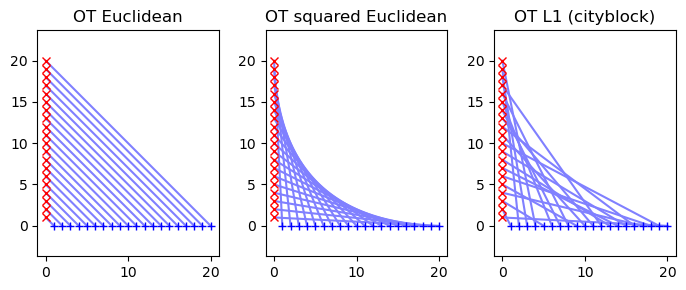

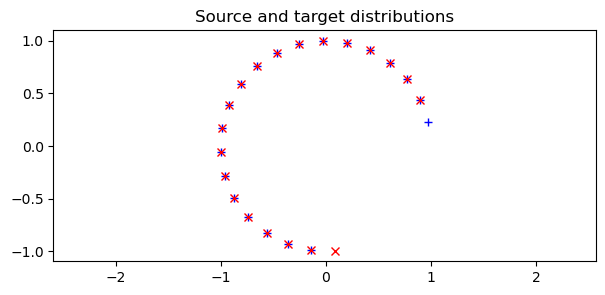

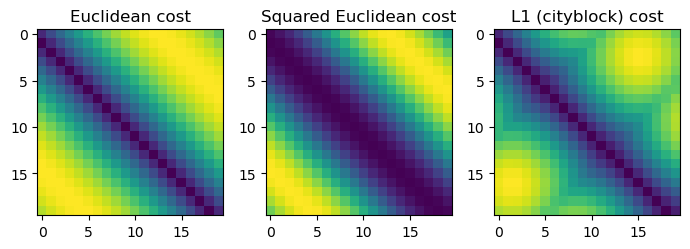

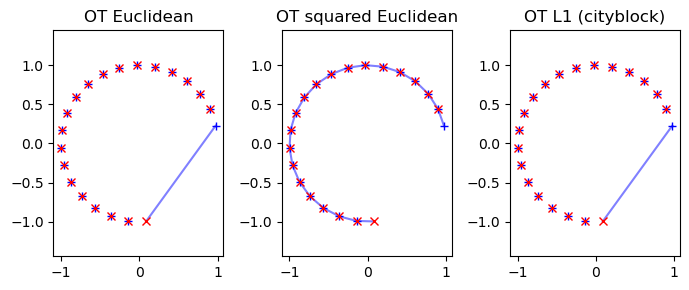

In [51]:
# -*- coding: utf-8 -*-
"""
================================================
Optimal Transport with different ground metrics
================================================

2D OT on empirical distribution with different ground metric.

Stole the figure idea from Fig. 1 and 2 in
https://arxiv.org/pdf/1706.07650.pdf


"""

# Author: Remi Flamary <remi.flamary@unice.fr>
#
# License: MIT License

# sphinx_gallery_thumbnail_number = 3

import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot

# %%
# Dataset 1 : uniform sampling
# ----------------------------

n = 20  # nb samples
xs = np.zeros((n, 2))
xs[:, 0] = np.arange(n) + 1
xs[:, 1] = (np.arange(n) + 1) * -0.001  # to make it strictly convex...

xt = np.zeros((n, 2))
xt[:, 1] = np.arange(n) + 1

a, b = ot.unif(n), ot.unif(n)  # uniform distribution on samples

# loss matrix
M1 = ot.dist(xs, xt, metric='euclidean')
M1 /= M1.max()

# loss matrix
M2 = ot.dist(xs, xt, metric='sqeuclidean')
M2 /= M2.max()

# loss matrix
Mp = ot.dist(xs, xt, metric='cityblock')
Mp /= Mp.max()

# Data
pl.figure(1, figsize=(7, 3))
pl.clf()
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.axis('equal')
pl.title('Source and target distributions')


# Cost matrices
pl.figure(2, figsize=(7, 3))

pl.subplot(1, 3, 1)
pl.imshow(M1, interpolation='nearest')
pl.title('Euclidean cost')

pl.subplot(1, 3, 2)
pl.imshow(M2, interpolation='nearest')
pl.title('Squared Euclidean cost')

pl.subplot(1, 3, 3)
pl.imshow(Mp, interpolation='nearest')
pl.title('L1 (cityblock cost')
pl.tight_layout()

##############################################################################
# Dataset 1 : Plot OT Matrices
# ----------------------------


#%% EMD
G1 = ot.emd(a, b, M1)
G2 = ot.emd(a, b, M2)
Gp = ot.emd(a, b, Mp)

# OT matrices
pl.figure(3, figsize=(7, 3))

pl.subplot(1, 3, 1)
ot.plot.plot2D_samples_mat(xs, xt, G1, c=[.5, .5, 1])
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.axis('equal')
# pl.legend(loc=0)
pl.title('OT Euclidean')

pl.subplot(1, 3, 2)
ot.plot.plot2D_samples_mat(xs, xt, G2, c=[.5, .5, 1])
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.axis('equal')
# pl.legend(loc=0)
pl.title('OT squared Euclidean')

pl.subplot(1, 3, 3)
ot.plot.plot2D_samples_mat(xs, xt, Gp, c=[.5, .5, 1])
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.axis('equal')
# pl.legend(loc=0)
pl.title('OT L1 (cityblock)')
pl.tight_layout()

pl.show()


# %%
# Dataset 2 : Partial circle
# --------------------------

n = 20  # nb samples
xtot = np.zeros((n + 1, 2))
xtot[:, 0] = np.cos(
    (np.arange(n + 1) + 1.0) * 0.8 / (n + 2) * 2 * np.pi)
xtot[:, 1] = np.sin(
    (np.arange(n + 1) + 1.0) * 0.8 / (n + 2) * 2 * np.pi)

xs = xtot[:n, :]
xt = xtot[1:, :]

a, b = ot.unif(n), ot.unif(n)  # uniform distribution on samples

# loss matrix
M1 = ot.dist(xs, xt, metric='euclidean')
M1 /= M1.max()

# loss matrix
M2 = ot.dist(xs, xt, metric='sqeuclidean')
M2 /= M2.max()

# loss matrix
Mp = ot.dist(xs, xt, metric='cityblock')
Mp /= Mp.max()


# Data
pl.figure(4, figsize=(7, 3))
pl.clf()
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.axis('equal')
pl.title('Source and target distributions')


# Cost matrices
pl.figure(5, figsize=(7, 3))

pl.subplot(1, 3, 1)
pl.imshow(M1, interpolation='nearest')
pl.title('Euclidean cost')

pl.subplot(1, 3, 2)
pl.imshow(M2, interpolation='nearest')
pl.title('Squared Euclidean cost')

pl.subplot(1, 3, 3)
pl.imshow(Mp, interpolation='nearest')
pl.title('L1 (cityblock) cost')
pl.tight_layout()

##############################################################################
# Dataset 2 : Plot  OT Matrices
# -----------------------------
#

#%% EMD
G1 = ot.emd(a, b, M1)
G2 = ot.emd(a, b, M2)
Gp = ot.emd(a, b, Mp)

# OT matrices
pl.figure(6, figsize=(7, 3))

pl.subplot(1, 3, 1)
ot.plot.plot2D_samples_mat(xs, xt, G1, c=[.5, .5, 1])
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.axis('equal')
# pl.legend(loc=0)
pl.title('OT Euclidean')

pl.subplot(1, 3, 2)
ot.plot.plot2D_samples_mat(xs, xt, G2, c=[.5, .5, 1])
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.axis('equal')
# pl.legend(loc=0)
pl.title('OT squared Euclidean')

pl.subplot(1, 3, 3)
ot.plot.plot2D_samples_mat(xs, xt, Gp, c=[.5, .5, 1])
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.axis('equal')
# pl.legend(loc=0)
pl.title('OT L1 (cityblock)')
pl.tight_layout()

pl.show()

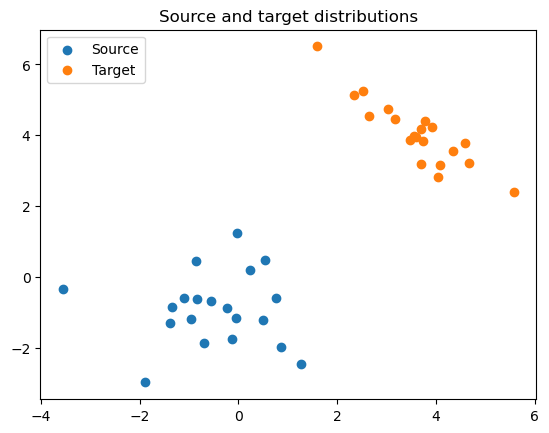

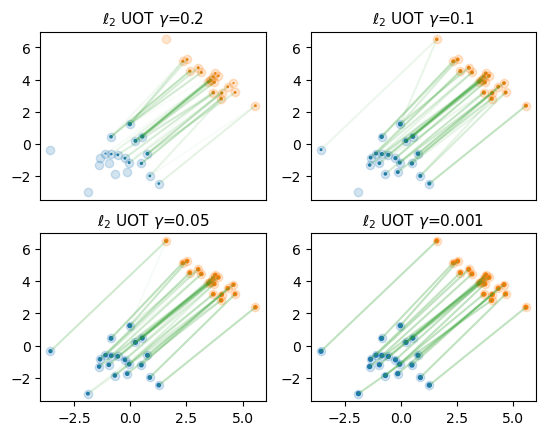

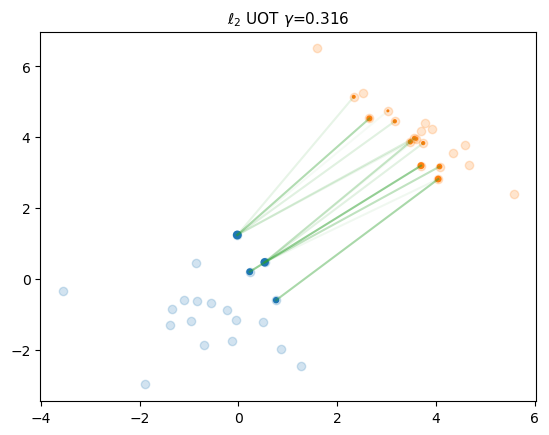

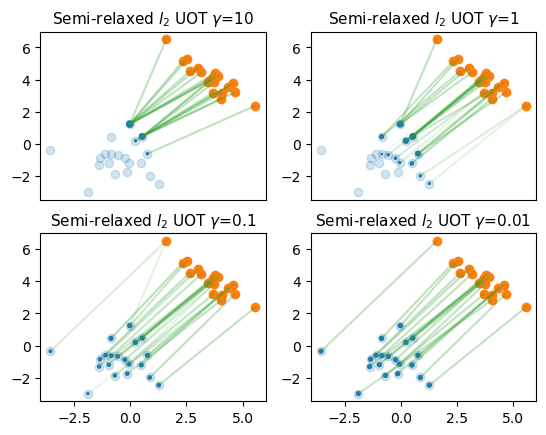

/algdata01/wei.wei/anaconda3/envs/zoe/lib/python3.9/site-packages/matplotlib/animation.py:879: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


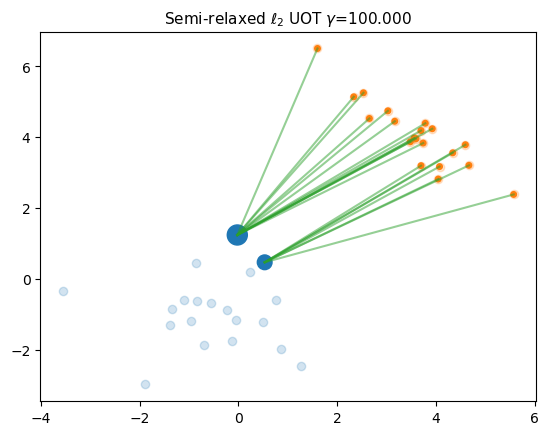

In [6]:
# -*- coding: utf-8 -*-
"""
================================================================
Regularization path of l2-penalized unbalanced optimal transport
================================================================
This example illustrate the regularization path for 2D unbalanced
optimal transport. We present here both the fully relaxed case
and the semi-relaxed case.

[Chapel et al., 2021] Chapel, L., Flamary, R., Wu, H., Févotte, C.,
and Gasso, G. (2021). Unbalanced optimal transport through non-negative
penalized linear regression.
"""

# Author: Haoran Wu <haoran.wu@univ-ubs.fr>
# License: MIT License

# sphinx_gallery_thumbnail_number = 2

import numpy as np
import matplotlib.pylab as pl
import ot
import matplotlib.animation as animation
##############################################################################
# Generate data
# -------------

#%% parameters and data generation

n = 20  # nb samples

mu_s = np.array([-1, -1])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

np.random.seed(0)
xs = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)

a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)
M /= M.max()

##############################################################################
# Plot data
# ---------

#%% plot 2 distribution samples

pl.figure(1)
pl.scatter(xs[:, 0], xs[:, 1], c='C0', label='Source')
pl.scatter(xt[:, 0], xt[:, 1], c='C1', label='Target')
pl.legend(loc=2)
pl.title('Source and target distributions')
pl.show()

##############################################################################
# Compute semi-relaxed and fully relaxed regularization paths
# -----------------------------------------------------------

#%%
final_gamma = 1e-6
t, t_list, g_list = ot.regpath.regularization_path(a, b, M, reg=final_gamma,
                                                   semi_relaxed=False)
t2, t_list2, g_list2 = ot.regpath.regularization_path(a, b, M, reg=final_gamma,
                                                      semi_relaxed=True)


##############################################################################
# Plot the regularization path
# ----------------------------
#
# The OT plan is plotted as a function of $\gamma$ that is the inverse of the
# weight on the marginal relaxations.

#%% fully relaxed l2-penalized UOT

pl.figure(2)
selected_gamma = [2e-1, 1e-1, 5e-2, 1e-3]
for p in range(4):
    tp = ot.regpath.compute_transport_plan(selected_gamma[p], g_list,
                                           t_list)
    P = tp.reshape((n, n))
    pl.subplot(2, 2, p + 1)
    if P.sum() > 0:
        P = P / P.max()
    for i in range(n):
        for j in range(n):
            if P[i, j] > 0:
                pl.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]], color='C2',
                        alpha=P[i, j] * 0.3)
    pl.scatter(xs[:, 0], xs[:, 1], c='C0', alpha=0.2)
    pl.scatter(xt[:, 0], xt[:, 1], c='C1', alpha=0.2)
    pl.scatter(xs[:, 0], xs[:, 1], c='C0', s=P.sum(1).ravel() * (1 + p) * 2,
               label='Re-weighted source', alpha=1)
    pl.scatter(xt[:, 0], xt[:, 1], c='C1', s=P.sum(0).ravel() * (1 + p) * 2,
               label='Re-weighted target', alpha=1)
    pl.plot([], [], color='C2', alpha=0.8, label='OT plan')
    pl.title(r'$\ell_2$ UOT $\gamma$={}'.format(selected_gamma[p]),
             fontsize=11)
    if p < 2:
        pl.xticks(())
pl.show()


# %%
# Animation of the regpath for UOT l2
# -----------------------------------

nv = 50
g_list_v = np.logspace(-.5, -2.5, nv)

pl.figure(3)


def _update_plot(iv):
    pl.clf()
    tp = ot.regpath.compute_transport_plan(g_list_v[iv], g_list,
                                           t_list)
    P = tp.reshape((n, n))
    if P.sum() > 0:
        P = P / P.max()
    for i in range(n):
        for j in range(n):
            if P[i, j] > 0:
                pl.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]], color='C2',
                        alpha=P[i, j] * 0.5)
    pl.scatter(xs[:, 0], xs[:, 1], c='C0', alpha=0.2)
    pl.scatter(xt[:, 0], xt[:, 1], c='C1', alpha=0.2)
    pl.scatter(xs[:, 0], xs[:, 1], c='C0', s=P.sum(1).ravel() * (1 + p) * 4,
               label='Re-weighted source', alpha=1)
    pl.scatter(xt[:, 0], xt[:, 1], c='C1', s=P.sum(0).ravel() * (1 + p) * 4,
               label='Re-weighted target', alpha=1)
    pl.plot([], [], color='C2', alpha=0.8, label='OT plan')
    pl.title(r'$\ell_2$ UOT $\gamma$={:1.3f}'.format(g_list_v[iv]),
             fontsize=11)
    return 1


i = 0
_update_plot(i)

ani = animation.FuncAnimation(pl.gcf(), _update_plot, nv, interval=100, repeat_delay=2000)


##############################################################################
# Plot the semi-relaxed regularization path
# -----------------------------------------

#%% semi-relaxed l2-penalized UOT

pl.figure(4)
selected_gamma = [10, 1, 1e-1, 1e-2]
for p in range(4):
    tp = ot.regpath.compute_transport_plan(selected_gamma[p], g_list2,
                                           t_list2)
    P = tp.reshape((n, n))
    pl.subplot(2, 2, p + 1)
    if P.sum() > 0:
        P = P / P.max()
    for i in range(n):
        for j in range(n):
            if P[i, j] > 0:
                pl.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]], color='C2',
                        alpha=P[i, j] * 0.3)
    pl.scatter(xs[:, 0], xs[:, 1], c='C0', alpha=0.2)
    pl.scatter(xt[:, 0], xt[:, 1], c='C1', alpha=1, label='Target marginal')
    pl.scatter(xs[:, 0], xs[:, 1], c='C0', s=P.sum(1).ravel() * 2 * (1 + p),
               label='Source marginal', alpha=1)
    pl.plot([], [], color='C2', alpha=0.8, label='OT plan')
    pl.title(r'Semi-relaxed $l_2$ UOT $\gamma$={}'.format(selected_gamma[p]),
             fontsize=11)
    if p < 2:
        pl.xticks(())
pl.show()


# %%
# Animation of the regpath for semi-relaxed UOT l2
# ------------------------------------------------

nv = 50
g_list_v = np.logspace(2, -2, nv)

pl.figure(5)


def _update_plot(iv):
    pl.clf()
    tp = ot.regpath.compute_transport_plan(g_list_v[iv], g_list2,
                                           t_list2)
    P = tp.reshape((n, n))
    if P.sum() > 0:
        P = P / P.max()
    for i in range(n):
        for j in range(n):
            if P[i, j] > 0:
                pl.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]], color='C2',
                        alpha=P[i, j] * 0.5)
    pl.scatter(xs[:, 0], xs[:, 1], c='C0', alpha=0.2)
    pl.scatter(xt[:, 0], xt[:, 1], c='C1', alpha=0.2)
    pl.scatter(xs[:, 0], xs[:, 1], c='C0', s=P.sum(1).ravel() * (1 + p) * 4,
               label='Re-weighted source', alpha=1)
    pl.scatter(xt[:, 0], xt[:, 1], c='C1', s=P.sum(0).ravel() * (1 + p) * 4,
               label='Re-weighted target', alpha=1)
    pl.plot([], [], color='C2', alpha=0.8, label='OT plan')
    pl.title(r'Semi-relaxed $\ell_2$ UOT $\gamma$={:1.3f}'.format(g_list_v[iv]),
             fontsize=11)
    return 1


i = 0
_update_plot(i)

ani = animation.FuncAnimation(pl.gcf(), _update_plot, nv, interval=100, repeat_delay=2000)

/algdata01/wei.wei/anaconda3/envs/zoe/lib/python3.9/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


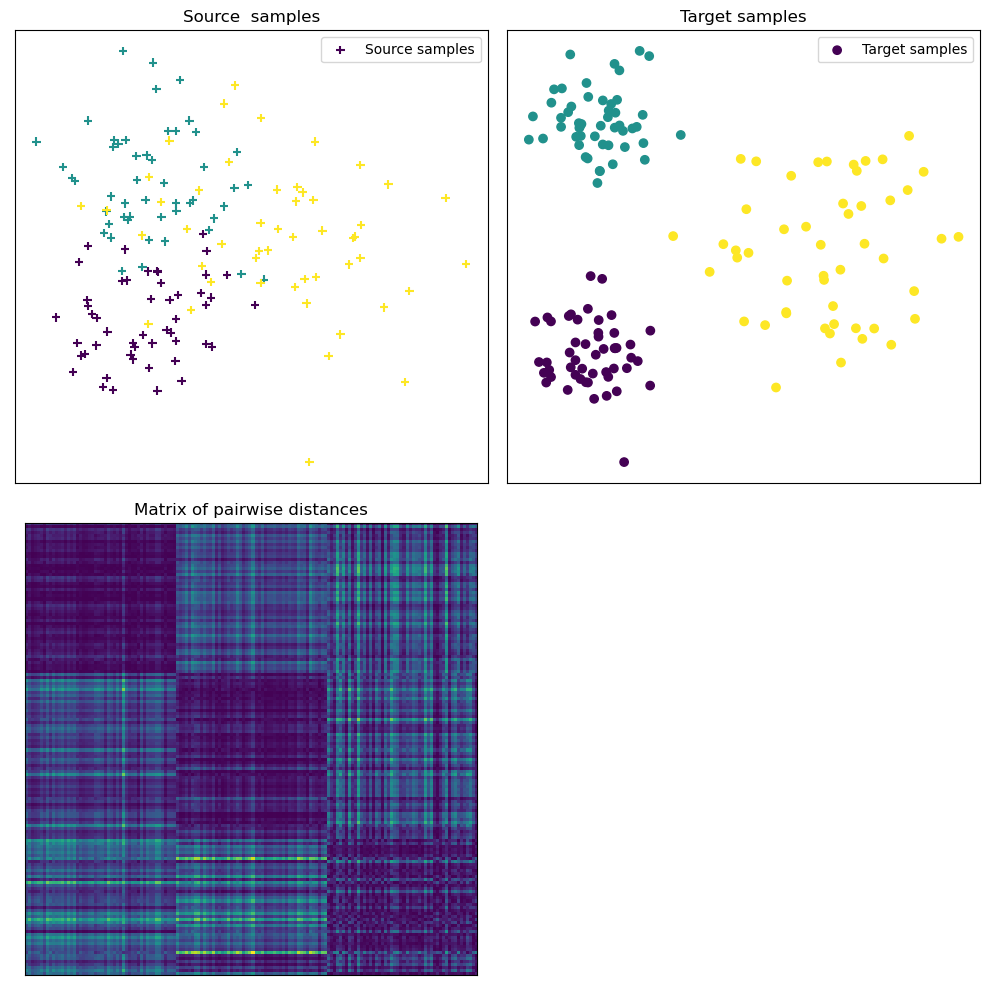

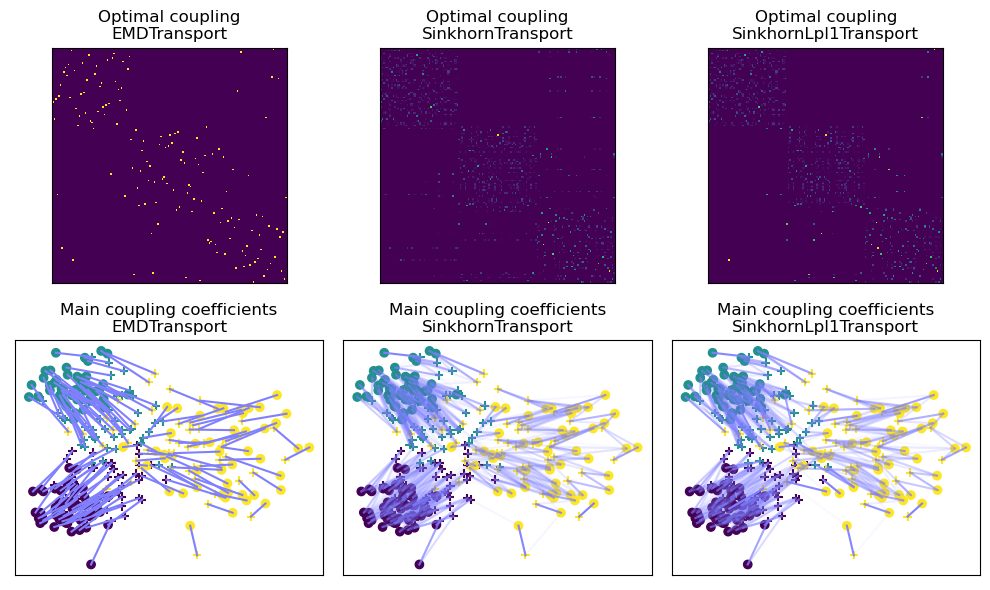

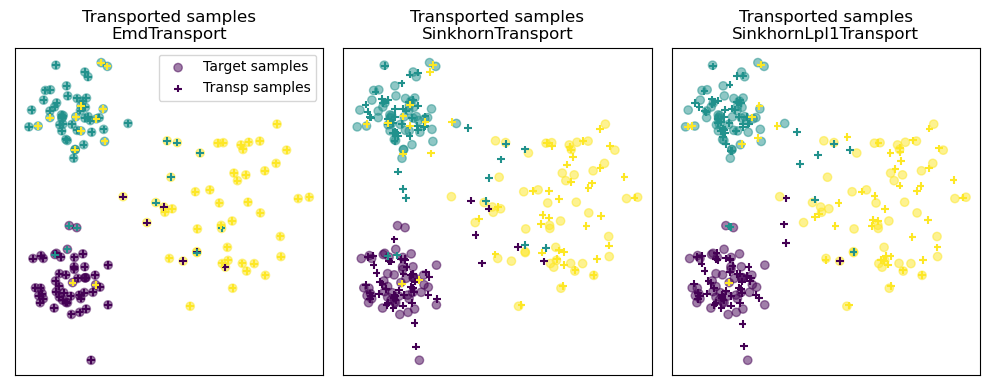

In [1]:
# -*- coding: utf-8 -*-
"""
===================================================
OT for domain adaptation on empirical distributions
===================================================

This example introduces a domain adaptation in a 2D setting. It explicits
the problem of domain adaptation and introduces some optimal transport
approaches to solve it.

Quantities such as optimal couplings, greater coupling coefficients and
transported samples are represented in order to give a visual understanding
of what the transport methods are doing.
"""

# Authors: Remi Flamary <remi.flamary@unice.fr>
#          Stanislas Chambon <stan.chambon@gmail.com>
#
# License: MIT License

# sphinx_gallery_thumbnail_number = 2

import matplotlib.pylab as pl
import ot
import ot.plot

##############################################################################
# Generate data
# -------------

n_samples_source = 150
n_samples_target = 150

Xs, ys = ot.datasets.make_data_classif('3gauss', n_samples_source)
Xt, yt = ot.datasets.make_data_classif('3gauss2', n_samples_target)

# Cost matrix
M = ot.dist(Xs, Xt, metric='sqeuclidean')


##############################################################################
# Instantiate the different transport algorithms and fit them
# -----------------------------------------------------------

# EMD Transport
ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=Xs, Xt=Xt)

# Sinkhorn Transport
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
ot_sinkhorn.fit(Xs=Xs, Xt=Xt)

# Sinkhorn Transport with Group lasso regularization
ot_lpl1 = ot.da.SinkhornLpl1Transport(reg_e=1e-1, reg_cl=1e0)
ot_lpl1.fit(Xs=Xs, ys=ys, Xt=Xt)

# transport source samples onto target samples
transp_Xs_emd = ot_emd.transform(Xs=Xs)
transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=Xs)
transp_Xs_lpl1 = ot_lpl1.transform(Xs=Xs)


##############################################################################
# Fig 1 : plots source and target samples + matrix of pairwise distance
# ---------------------------------------------------------------------

pl.figure(1, figsize=(10, 10))
pl.subplot(2, 2, 1)
pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='+', label='Source samples')
pl.xticks([])
pl.yticks([])
pl.legend(loc=0)
pl.title('Source  samples')

pl.subplot(2, 2, 2)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
pl.xticks([])
pl.yticks([])
pl.legend(loc=0)
pl.title('Target samples')

pl.subplot(2, 2, 3)
pl.imshow(M, interpolation='nearest')
pl.xticks([])
pl.yticks([])
pl.title('Matrix of pairwise distances')
pl.tight_layout()


##############################################################################
# Fig 2 : plots optimal couplings for the different methods
# ---------------------------------------------------------
pl.figure(2, figsize=(10, 6))

pl.subplot(2, 3, 1)
pl.imshow(ot_emd.coupling_, interpolation='nearest')
pl.xticks([])
pl.yticks([])
pl.title('Optimal coupling\nEMDTransport')

pl.subplot(2, 3, 2)
pl.imshow(ot_sinkhorn.coupling_, interpolation='nearest')
pl.xticks([])
pl.yticks([])
pl.title('Optimal coupling\nSinkhornTransport')

pl.subplot(2, 3, 3)
pl.imshow(ot_lpl1.coupling_, interpolation='nearest')
pl.xticks([])
pl.yticks([])
pl.title('Optimal coupling\nSinkhornLpl1Transport')

pl.subplot(2, 3, 4)
ot.plot.plot2D_samples_mat(Xs, Xt, ot_emd.coupling_, c=[.5, .5, 1])
pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='+', label='Source samples')
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
pl.xticks([])
pl.yticks([])
pl.title('Main coupling coefficients\nEMDTransport')

pl.subplot(2, 3, 5)
ot.plot.plot2D_samples_mat(Xs, Xt, ot_sinkhorn.coupling_, c=[.5, .5, 1])
pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='+', label='Source samples')
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
pl.xticks([])
pl.yticks([])
pl.title('Main coupling coefficients\nSinkhornTransport')

pl.subplot(2, 3, 6)
ot.plot.plot2D_samples_mat(Xs, Xt, ot_lpl1.coupling_, c=[.5, .5, 1])
pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='+', label='Source samples')
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
pl.xticks([])
pl.yticks([])
pl.title('Main coupling coefficients\nSinkhornLpl1Transport')
pl.tight_layout()


##############################################################################
# Fig 3 : plot transported samples
# --------------------------------

# display transported samples
pl.figure(4, figsize=(10, 4))
pl.subplot(1, 3, 1)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.5)
pl.scatter(transp_Xs_emd[:, 0], transp_Xs_emd[:, 1], c=ys,
           marker='+', label='Transp samples', s=30)
pl.title('Transported samples\nEmdTransport')
pl.legend(loc=0)
pl.xticks([])
pl.yticks([])

pl.subplot(1, 3, 2)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.5)
pl.scatter(transp_Xs_sinkhorn[:, 0], transp_Xs_sinkhorn[:, 1], c=ys,
           marker='+', label='Transp samples', s=30)
pl.title('Transported samples\nSinkhornTransport')
pl.xticks([])
pl.yticks([])

pl.subplot(1, 3, 3)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.5)
pl.scatter(transp_Xs_lpl1[:, 0], transp_Xs_lpl1[:, 1], c=ys,
           marker='+', label='Transp samples', s=30)
pl.title('Transported samples\nSinkhornLpl1Transport')
pl.xticks([])
pl.yticks([])

pl.tight_layout()
pl.show()

/algdata01/wei.wei/anaconda3/envs/zoe/lib/python3.9/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


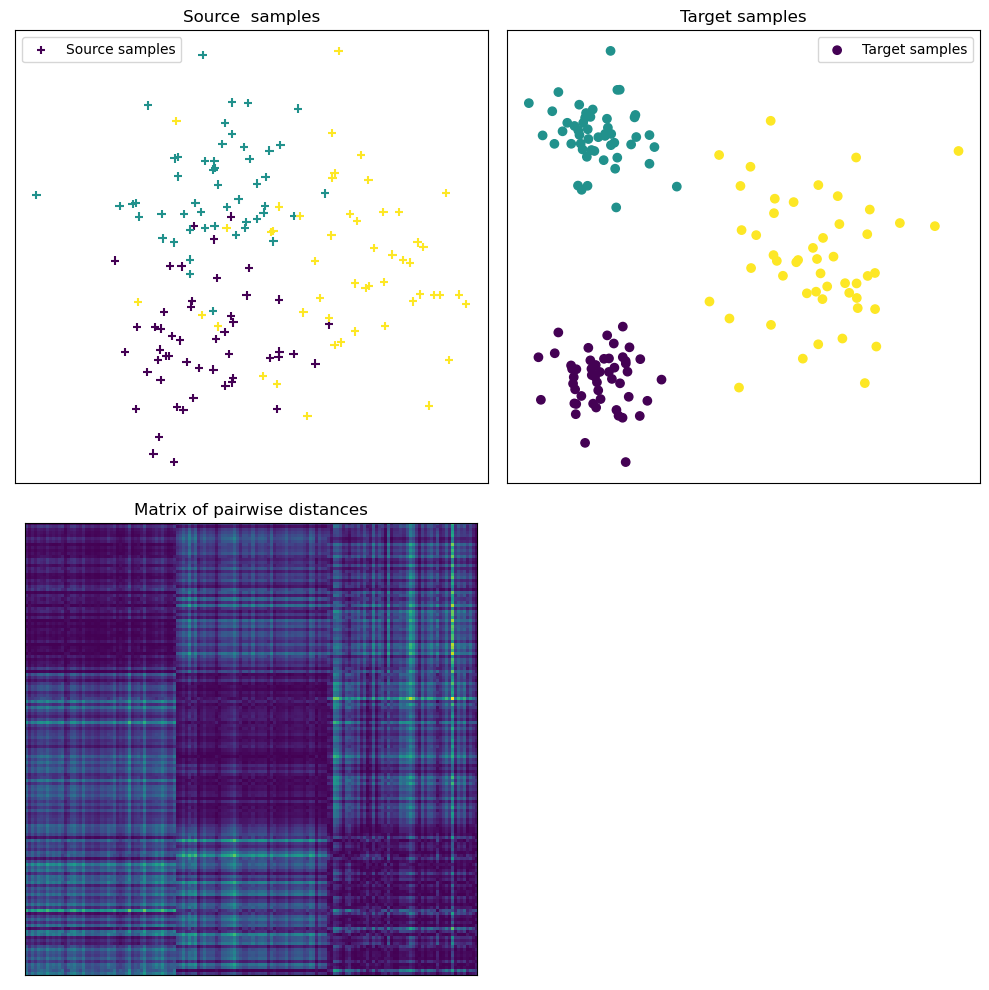

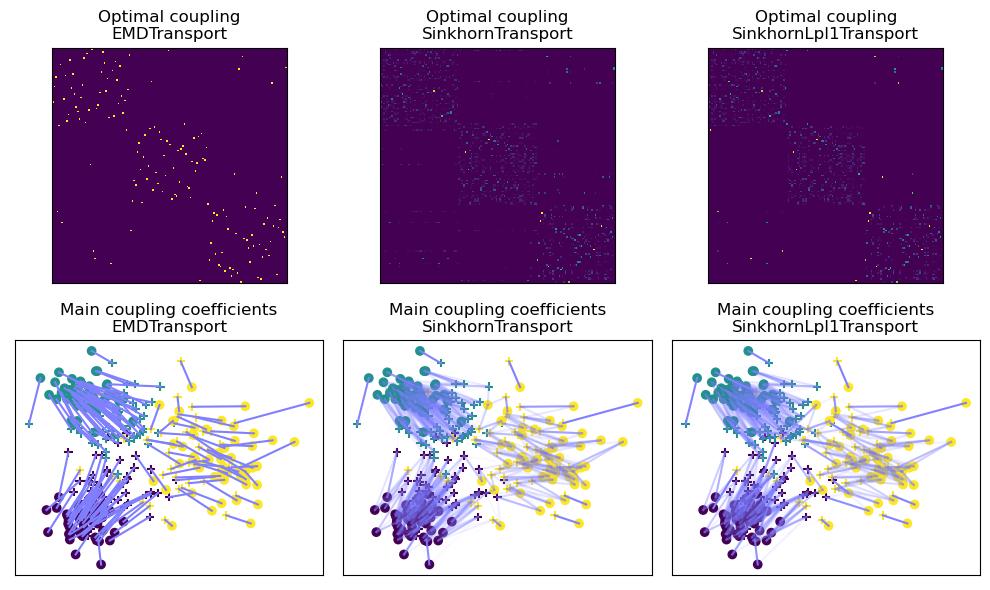

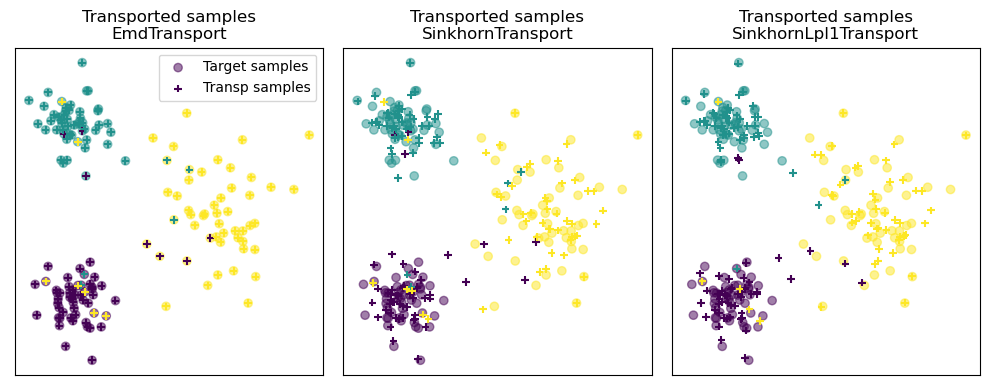

In [40]:
n_samples_source = 150
n_samples_target = 150

Xs, ys = ot.datasets.make_data_classif('3gauss', n_samples_source)
Xt, yt = ot.datasets.make_data_classif('3gauss2', n_samples_target)

# Cost matrix
M = ot.dist(Xs, Xt, metric='sqeuclidean')


##############################################################################
# Instantiate the different transport algorithms and fit them
# -----------------------------------------------------------

# EMD Transport
ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=Xs, Xt=Xt)

# Sinkhorn Transport
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
ot_sinkhorn.fit(Xs=Xs, Xt=Xt)

# Sinkhorn Transport with Group lasso regularization
ot_lpl1 = ot.da.SinkhornLpl1Transport(reg_e=1e-1, reg_cl=1e0)
ot_lpl1.fit(Xs=Xs, ys=ys, Xt=Xt)

# transport source samples onto target samples
transp_Xs_emd = ot_emd.transform(Xs=Xs)
transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=Xs)
transp_Xs_lpl1 = ot_lpl1.transform(Xs=Xs)


##############################################################################
# Fig 1 : plots source and target samples + matrix of pairwise distance
# ---------------------------------------------------------------------

pl.figure(1, figsize=(10, 10))
pl.subplot(2, 2, 1)
pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='+', label='Source samples')
pl.xticks([])
pl.yticks([])
pl.legend(loc=0)
pl.title('Source  samples')

pl.subplot(2, 2, 2)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
pl.xticks([])
pl.yticks([])
pl.legend(loc=0)
pl.title('Target samples')

pl.subplot(2, 2, 3)
pl.imshow(M, interpolation='nearest')
pl.xticks([])
pl.yticks([])
pl.title('Matrix of pairwise distances')
pl.tight_layout()


##############################################################################
# Fig 2 : plots optimal couplings for the different methods
# ---------------------------------------------------------
pl.figure(2, figsize=(10, 6))

pl.subplot(2, 3, 1)
pl.imshow(ot_emd.coupling_, interpolation='nearest')
pl.xticks([])
pl.yticks([])
pl.title('Optimal coupling\nEMDTransport')

pl.subplot(2, 3, 2)
pl.imshow(ot_sinkhorn.coupling_, interpolation='nearest')
pl.xticks([])
pl.yticks([])
pl.title('Optimal coupling\nSinkhornTransport')

pl.subplot(2, 3, 3)
pl.imshow(ot_lpl1.coupling_, interpolation='nearest')
pl.xticks([])
pl.yticks([])
pl.title('Optimal coupling\nSinkhornLpl1Transport')

pl.subplot(2, 3, 4)
ot.plot.plot2D_samples_mat(Xs, Xt, ot_emd.coupling_, c=[.5, .5, 1])
pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='+', label='Source samples')
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
pl.xticks([])
pl.yticks([])
pl.title('Main coupling coefficients\nEMDTransport')

pl.subplot(2, 3, 5)
ot.plot.plot2D_samples_mat(Xs, Xt, ot_sinkhorn.coupling_, c=[.5, .5, 1])
pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='+', label='Source samples')
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
pl.xticks([])
pl.yticks([])
pl.title('Main coupling coefficients\nSinkhornTransport')

pl.subplot(2, 3, 6)
ot.plot.plot2D_samples_mat(Xs, Xt, ot_lpl1.coupling_, c=[.5, .5, 1])
pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='+', label='Source samples')
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
pl.xticks([])
pl.yticks([])
pl.title('Main coupling coefficients\nSinkhornLpl1Transport')
pl.tight_layout()


##############################################################################
# Fig 3 : plot transported samples
# --------------------------------

# display transported samples
pl.figure(4, figsize=(10, 4))
pl.subplot(1, 3, 1)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.5)
pl.scatter(transp_Xs_emd[:, 0], transp_Xs_emd[:, 1], c=ys,
           marker='+', label='Transp samples', s=30)
pl.title('Transported samples\nEmdTransport')
pl.legend(loc=0)
pl.xticks([])
pl.yticks([])

pl.subplot(1, 3, 2)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.5)
pl.scatter(transp_Xs_sinkhorn[:, 0], transp_Xs_sinkhorn[:, 1], c=ys,
           marker='+', label='Transp samples', s=30)
pl.title('Transported samples\nSinkhornTransport')
pl.xticks([])
pl.yticks([])

pl.subplot(1, 3, 3)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.5)
pl.scatter(transp_Xs_lpl1[:, 0], transp_Xs_lpl1[:, 1], c=ys,
           marker='+', label='Transp samples', s=30)
pl.title('Transported samples\nSinkhornLpl1Transport')
pl.xticks([])
pl.yticks([])

pl.tight_layout()
pl.show()

In [2]:
loan_amount = 200000  # Principal
annual_interest_rate = 3.1  # Annual interest rate
loan_term_years = 3  # Loan term in years

# Convert annual rate to monthly and percentage to decimal
monthly_interest_rate = (annual_interest_rate / 100) / 12
number_of_payments = loan_term_years * 12

# Monthly payment calculation
monthly_payment = loan_amount * (monthly_interest_rate * (1 + monthly_interest_rate) ** number_of_payments) / ((1 + monthly_interest_rate) ** number_of_payments - 1)

# Total amount paid over the life of the loan
total_paid = monthly_payment * number_of_payments

# Total interest paid
total_interest_paid = total_paid - loan_amount

print(f"Monthly payment: ${monthly_payment:.2f}")
print(f"Total paid over the life of the loan: ${total_paid:.2f}")
print(f"Total interest paid: ${total_interest_paid:.2f}")


Monthly payment: $5825.06
Total paid over the life of the loan: $209702.17
Total interest paid: $9702.17


In [3]:
loan_amount = 200000  # Initial principal
annual_interest_rate = 3.1  # Annual interest rate
payment_percentage = 30  # Percentage of the original loan amount paid each year

total_interest_paid = 0  # Initialize total interest paid

current_principal = loan_amount  # Initialize current principal to the loan amount

for year in range(1, 4):  # Loop through each of the 3 years
    # Calculate interest for the year
    interest_for_year = current_principal * (annual_interest_rate / 100)
    
    # Add the interest for the year to the total interest paid
    total_interest_paid += interest_for_year
    
    # Calculate payment amount (30% of the original loan amount)
    payment_amount = loan_amount * (payment_percentage / 100)
    
    # Reduce the current principal by the payment amount
    current_principal -= payment_amount
    
    print(f"Year {year}:")
    print(f"  Interest for the year: ${interest_for_year:.2f}")
    print(f"  Payment made: ${payment_amount:.2f}")
    print(f"  Remaining principal: ${current_principal:.2f}\n")

print(f"Total interest paid over 3 years: ${total_interest_paid:.2f}")

Year 1:
  Interest for the year: $6200.00
  Payment made: $60000.00
  Remaining principal: $140000.00

Year 2:
  Interest for the year: $4340.00
  Payment made: $60000.00
  Remaining principal: $80000.00

Year 3:
  Interest for the year: $2480.00
  Payment made: $60000.00
  Remaining principal: $20000.00

Total interest paid over 3 years: $13020.00


In [4]:
loan_amount = 200000  # Initial principal
annual_interest_rate = 3.1  # Annual interest rate in percent
repayment_percentage_of_original = 30  # Percentage of the original loan amount paid each year

total_interest_paid = 0  # Initialize total interest paid

current_principal = loan_amount  # Initialize current principal to the loan amount

for year in range(1, 4):  # Loop through each of the 3 years
    # Calculate interest for the current year
    interest_for_year = current_principal * (annual_interest_rate / 100)
    
    # Update total interest paid
    total_interest_paid += interest_for_year
    
    # Update principal by adding the interest for the year (compound interest)
    current_principal += interest_for_year
    
    # Calculate payment amount as a percentage of the original loan amount
    payment_amount = loan_amount * (repayment_percentage_of_original / 100)
    
    # Subtract the annual repayment from the current principal
    current_principal -= payment_amount
    
    print(f"Year {year}:")
    print(f"  Interest for the year: ${interest_for_year:.2f}")
    print(f"  Payment made: ${payment_amount:.2f}")
    print(f"  Remaining principal: ${current_principal:.2f}\n")

print(f"Total interest paid over 3 years: ${total_interest_paid:.2f}")


Year 1:
  Interest for the year: $6200.00
  Payment made: $60000.00
  Remaining principal: $146200.00

Year 2:
  Interest for the year: $4532.20
  Payment made: $60000.00
  Remaining principal: $90732.20

Year 3:
  Interest for the year: $2812.70
  Payment made: $60000.00
  Remaining principal: $33544.90

Total interest paid over 3 years: $13544.90
